**Implementation of a Trinomial tree model for European and American floating strike lookback put option**

(A)

We use an N-period trinomial tree with Kamrad-Ritchken parametrisation to price European and Amerian floating strike lookback put options with payoff  
$\displaystyle (\max_{i=0,...,N}S_i-S_N)$ respectively.

\\

*The algorithm*

We set the notation that:

Let $V^n_{k,j}$ be the time-n option price when $S_n = s^n_k$ and $M_n = m^n_j$. Let $g^n_{k,j}$ be the intrinsic value of option when $S_n = s^n_k$ and $M_n = m^n_j$. $S_n$ and $M_n$ are the value of stock price and the auxiliary process at time $n$ respectively. 
 
\\

Then the pricing strategy is:

1.   Fix a tree model of stock price:
     
     We are using a trinomial tree model with KR specification. Then the possible node values of the stock price are
\begin{align*}
s^n_k=S_0 u^{n
-k},\quad n=0,1,...,N\quad k=0,1,...,2n
\end{align*}

2.   Pick an auxiliary variable:

     We choose $\displaystyle M_n:= \max_{i=0,...n}S_i$ representing the running maximum stock price between time zero and time $n$. The pay off function becomes
\begin{align*}
g(S_N, M_N):= M_N - S_N
\end{align*}
  
3.   Specify a grid of values for the auxiliary variable $M_n$:

     Construct the grid for $M_n$ as
\begin{align*}
m^n_j:= S_0u^{n-j}, \quad n=0,1,...,N\quad j=0,1,...,n
\end{align*}
     which represents the $j$-th possible value of $M_n$.

4.   Evolution of auxiliary variable as stock price changes:
     
     As
\begin{align*}
M_{n+1} = \max(M_n, S_{n+1}),
\end{align*}
     we have 
\begin{align*}
j_{new} = \min(k_{new},j+1) =: \phi(k_{new},j),
\end{align*}
     where $\phi(k_{new},j)$ is called the shooting function which describes the new state of the auxiliary variable $M$ when stock price moves to a new state $k_{new}$ and that the current state of $M$ is $j$.

5.   Write down the recursive equation for the fair option prices:

     For European floating strik lookback put option,
\begin{align*}
V^n_{k,j}=e^{-r\triangle t}[q_uV^{n+1}_{k,\phi(k,j)} + q_mV^{n+1}_{k+1,\phi(k+1,j)} + q_dV^{n+1}_{k+2,\phi(k+2,j)}] \quad k=0,1,...,2n \quad j=0,1,...,n
\end{align*}

     For American floating strik lookback put option, 
\begin{align*}
V^n_{k,j}= \max\{ g^n_{k,j}, e^{-r\triangle t}[q_uV^{n+1}_{k,\phi(k,j)} + q_mV^{n+1}_{k+1,\phi(k+1,j)} + q_dV^{n+1}_{k+2,\phi(k+2,j)}]\} \quad k=0,1,...,2n \quad j=0,1,...,n
\end{align*}

     We only need to consider the combination of $(k,j)$ such that $j \le k$.

Then the pricing algorithm is:

1.   Define notation:
\begin{align*}
s^n_k = S_0u^{n-k}, m^n_j = S_0u^{n-j} \quad n=0,1,...,N, \quad k = 0,1,...,2n \quad j = 0,1,...,n
\end{align*}

2.   Option price at terminal time $N$ is given by the payoff function:

     For each $k = 0,1,...,2N$, for each $j = 0,1,...,\min(k,N)$, compute
\begin{align*}
V^N_{k,j} = g(s^N_k,m^N_j) = m^N_j - s^N_k
\end{align*}

3.   Look backward in time.

     For each $k = 0,1,...,2n$, for each $j = 0,1,...,\min(k,n)$, compute
\begin{align*}
V^n_{k,j}=e^{-r\triangle t}[q_uV^{n+1}_{k,\phi(k,j)} + q_mV^{n+1}_{k+1,\phi(k+1,j)} + q_dV^{n+1}_{k+2,\phi(k+2,j)}]
\end{align*}
     for European floating strik lookback put option, compute
\begin{align*}
V^n_{k,j}= \max\{ g^n_{k,j}, e^{-r\triangle t}[q_uV^{n+1}_{k,\phi(k,j)} + q_mV^{n+1}_{k+1,\phi(k+1,j)} + q_dV^{n+1}_{k+2,\phi(k+2,j)}]\} \quad k=0,1,...,2n \quad j=0,1,...,n
\end{align*}
     for American floating strik lookback put option,
     where the shooting function is $\phi(k_{new},j):= \min(k_{new},j+1)$.

4.   The required time-zero option value is $V^0_{0,0}$.		  


(B)

Load the usual packages

In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import time

Implementation of the above pricing algorithm:

In [ ]:
def EuroLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, payoff):
  
    M = np.zeros((N+1,N+1))
    S = np.zeros((2*N+1, N+1))
    V = []
    
    for t in range(N+1):
      S[0:2*t+1, t] = s0 * u**np.arange(t, -t-1, -1)
    for t in range(N+1):
      M[0:t+1, t] = s0 * u**np.arange(t, -1, -1)

    # Compute the option price at terminal time
    V_N = np.zeros((2*N+1, N+1))
    for k in range(2*N+1):
      for j in range(min(k+1, N+1)):
        V_N[k][j] = payoff(M[j][N], S[k][N])
    V.append(V_N)
    
    # Loop backward in time
    for n in reversed(range(N)):
      V_n = np.zeros((2*n+1, n+1))
      for k in range(2*n+1):
        for j in range(min(k+1, n+1)):
          V_n[k][j] = (qu * V[N-n-1][k][min(k,j+1)] + qm * V[N-n-1][k+1][min(k+1,j+1)] + qd * V[N-n-1][k+2][min(k+2,j+1)]) / R
      V.append(V_n)
      print(n/N)

    V_fair = V[N][0][0]

    return V_fair

In [ ]:
def EuroLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, payoff):
  
    M = np.zeros((N+1,N+1))
    S = np.zeros((2*N+1, N+1))
    
    for t in range(N+1):
      S[0:2*t+1, t] = s0 * u**np.arange(t, -t-1, -1)
    for t in range(N+1):
      M[0:t+1, t] = s0 * u**np.arange(t, -1, -1)

    # Compute the option price at terminal time
    V_N = np.zeros((2*N+1, N+1))
    for k in range(2*N+1):
      for j in range(min(k+1, N+1)):
        V_N[k][j] = payoff(M[j][N], S[k][N])
    V_old = V_N
    
    # Loop backward in time
    for n in reversed(range(N)):
      V_n = np.zeros((2*n+1, n+1))
      for k in range(2*n+1):
        for j in range(min(k+1, n+1)):
          V_n[k][j] = (qu * V_old[k][min(k,j+1)] + qm * V_old[k+1][min(k+1,j+1)] + qd * V_old[k+2][min(k+2,j+1)]) / R
      V_old = V_n
      print(n/N)

    V_fair = V_n[0][0]

    return V_fair

In [ ]:
def AmerLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, payoff):
  
    M = np.zeros((N+1,N+1))
    S = np.zeros((2*N+1, N+1))
    V = []
    
    for t in range(N+1):
      S[0:2*t+1, t] = s0 * u**np.arange(t, -t-1, -1)
    for t in range(N+1):
      M[0:t+1, t] = s0 * u**np.arange(t, -1, -1)

    # Compute the option price at terminal time
    V_N = np.zeros((2*N+1, N+1))
    for k in range(2*N+1):
      for j in range(min(k+1, N+1)):
        V_N[k][j] = payoff(M[j][N], S[k][N])
    V.append(V_N)
    
    # Loop backward in time
    for n in reversed(range(N)):
      V_n = np.zeros((2*n+1, n+1))
      for k in range(2*n+1):
        for j in range(min(k+1, n+1)):
          V_n[k][j] = max(payoff(M[j][n], S[k][n]),(qu * V[N-n-1][k][min(k,j+1)] + qm * V[N-n-1][k+1][min(k+1,j+1)] + qd * V[N-n-1][k+2][min(k+2,j+1)]) / R)
      V.append(V_n)
      print(n/N)

    V_fair = V[N][0][0]

    return V_fair

In [ ]:
def AmerLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, payoff):
  
    M = np.zeros((N+1,N+1))
    S = np.zeros((2*N+1, N+1))
    
    for t in range(N+1):
      S[0:2*t+1, t] = s0 * u**np.arange(t, -t-1, -1)
    for t in range(N+1):
      M[0:t+1, t] = s0 * u**np.arange(t, -1, -1)

    # Compute the option price at terminal time
    V_N = np.zeros((2*N+1, N+1))
    for k in range(2*N+1):
      for j in range(min(k+1, N+1)):
        V_N[k][j] = payoff(M[j][N], S[k][N])
    V_old = V_N
    
    # Loop backward in time
    for n in reversed(range(N)):
      V_n = np.zeros((2*n+1, n+1))
      for k in range(2*n+1):
        for j in range(min(k+1, n+1)):
          V_n[k][j] = max(payoff(M[j][n], S[k][n]),(qu * V_old[k][min(k,j+1)] + qm * V_old[k+1][min(k+1,j+1)] + qd * V_old[k+2][min(k+2,j+1)]) / R)
      V_old = V_n
      print(n/N)

    V_fair = V_n[0][0]

    return V_fair

In [ ]:
PutPayoff = lambda x, y : max(x - y, 0) 

s0, r, T, sigma, lamb = 100, 0.01, 1, 0.2, 1.25
N = 2
u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)
AmerLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)

[[ 0.          0.          0.        ]
 [23.075444    0.          0.        ]
 [42.41190195 19.33645794  0.        ]
 [58.61521339 35.53976939 16.20331144]
 [72.19305182 49.11760781 29.78114987]]
[[ 6.42890036  0.        ]
 [19.33645794  5.38720561]
 [35.53976939 16.20331144]]
[[9.27344948]]


9.273449482855904

*Choosing the tree parameters*

There are a number of ways we can choose the tree parameters. We choose the Kamrad-Ritchken parametrisation here:
	\begin{align*}
	&q_u=\frac{1}{2\lambda^2} + \frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\lambda \sigma}, \quad q_m = 1 - \frac{1}{\lambda^2}, \quad q_d=\frac{1}{2\lambda^2} - \frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\lambda \sigma},\\
\\
&u=e^{\lambda \sigma \sqrt{\triangle t}},\quad m = 1, \quad d=e^{-\lambda \sigma \sqrt{\triangle t}}.
	\end{align*}

In [ ]:
def GetTrinomialKRPara(lamb, r, dt, sigma):
  u = np.exp(lamb * sigma * np.sqrt(dt))
  R = np.exp(r * dt)
  qu = 1/(2*lamb**2) + (r-sigma**2/2)*np.sqrt(dt)/(2*lamb*sigma)
  qm = 1 - 1/lamb**2
  qd = 1 - qu - qm
  return u, qu, qm, qd, R

Now we try to vary $N$ to price a European floating strike lookbck put option. Parameters are: initial stock price $S_0=100$, maturity $T=1$ year, interest rate $r=1\%$ and volatility $\sigma=20\%$.

In [ ]:
PutPayoff = lambda x, y : max(x - y, 0) 

s0, r, T, sigma, lamb = 100, 0.01, 1, 0.2, 1.25
N_range = [2000, 2500, 3000, 3500]
European_V_fairs = np.zeros(len(N_range))
American_V_fairs = np.zeros(len(N_range))
European_timetaken = np.zeros(len(N_range))
American_timetaken = np.zeros(len(N_range))

for i, N in enumerate(N_range):
  u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)
  start = time.process_time()     
  European_V_fairs[i] = EuroLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
  European_timetaken[i] = time.process_time() - start
  start = time.process_time()
  American_V_fairs[i] = AmerLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
  American_timetaken[i] = time.process_time() - start
  print(N)
  print(European_V_fairs[i])
  print(American_V_fairs[i])
  print(European_timetaken[i])
  print(American_timetaken[i])

  fig, ax = plt.subplots(figsize = (20, 10))
  ax.plot(N_range[:i+1], European_V_fairs[:i+1], label='European Lookback Put Price ')
  ax.plot(N_range[:i+1], American_V_fairs[:i+1], label='American Lookback Put Price ')
  ax.set_xlabel('$N$')
  ax.set_title('Floating Strike Lookback Put Option')
  ax.legend()
  plt.show()

1
7.445940430150458
7.445940430150458
0.00010326799997528724
8.338499992532888e-05


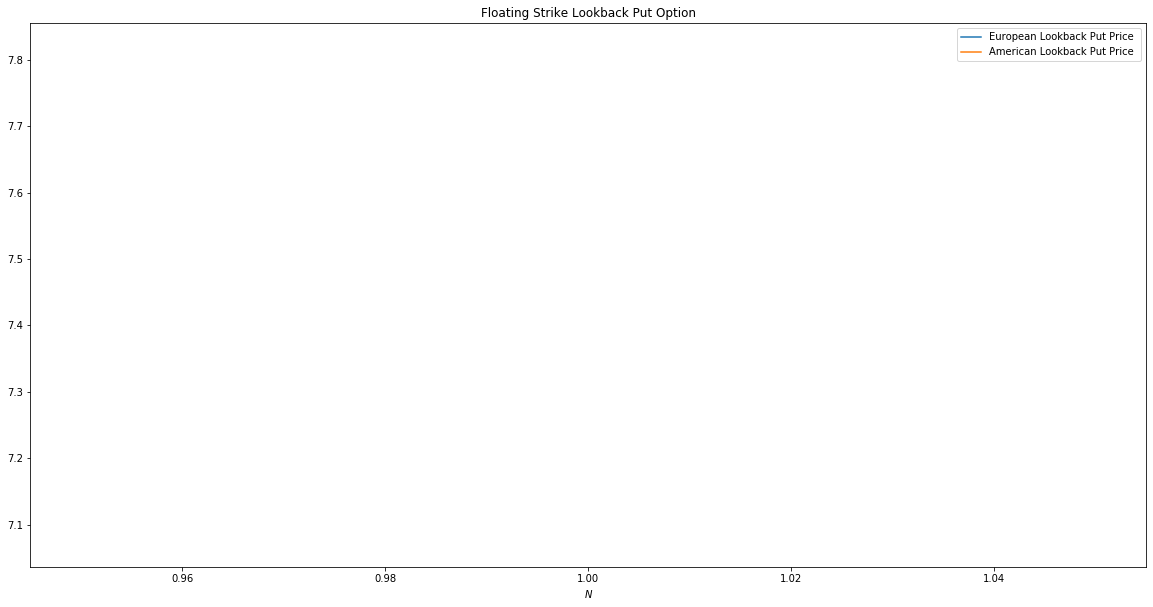

11
12.613779027290269
12.765810908206596
0.005658692000224619
0.004972533000000112


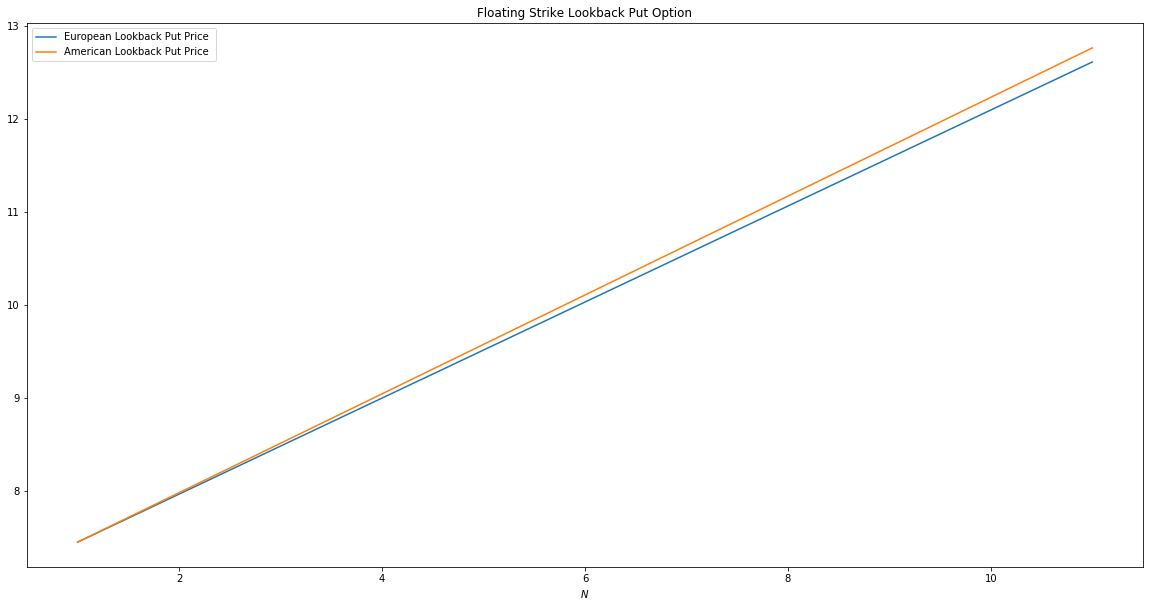

21
13.548085581700711
13.692586816789092
0.024959081000133665
0.032798353000089264


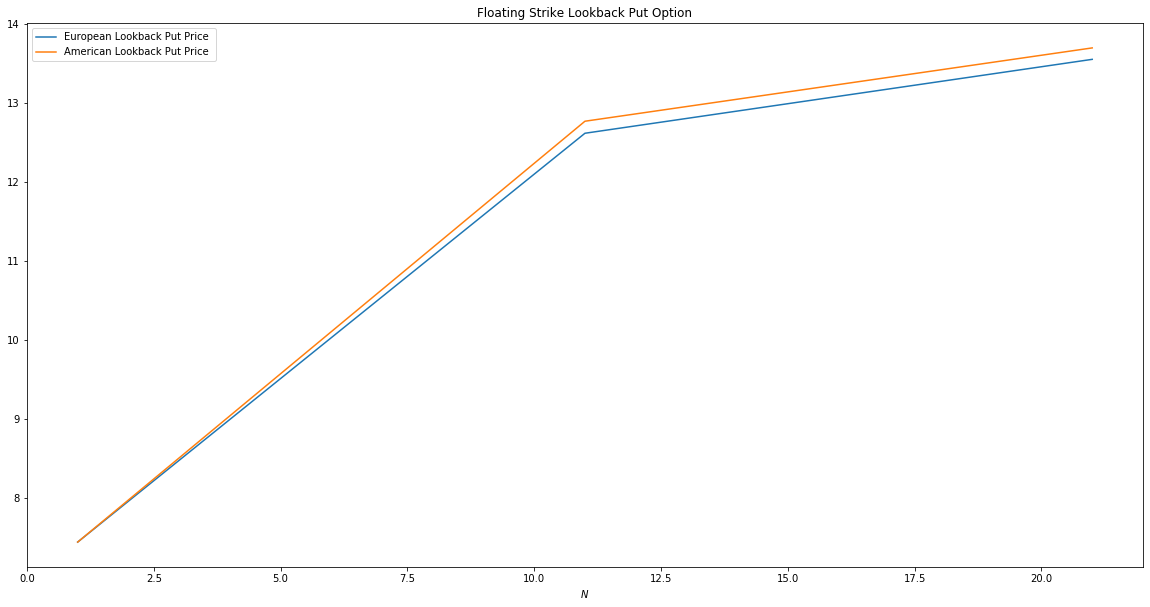

31
14.009731496993387
14.150810885606376
0.06870675300001494
0.0956149789999472


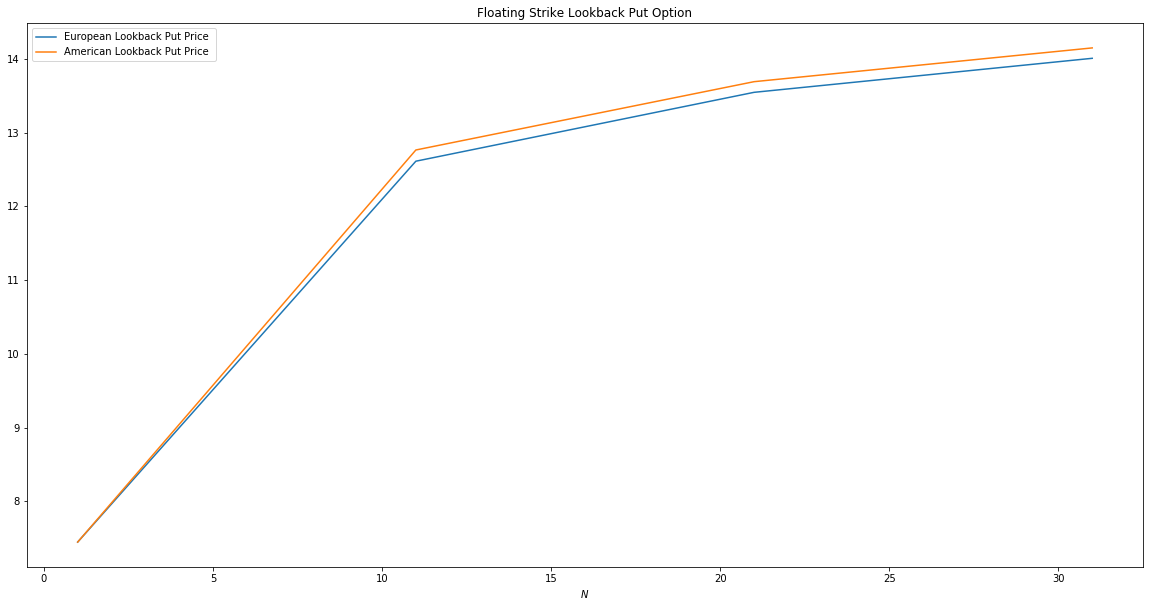

41
14.298957219773735
14.438477846112525
0.16428397899994707
0.20444708800005174


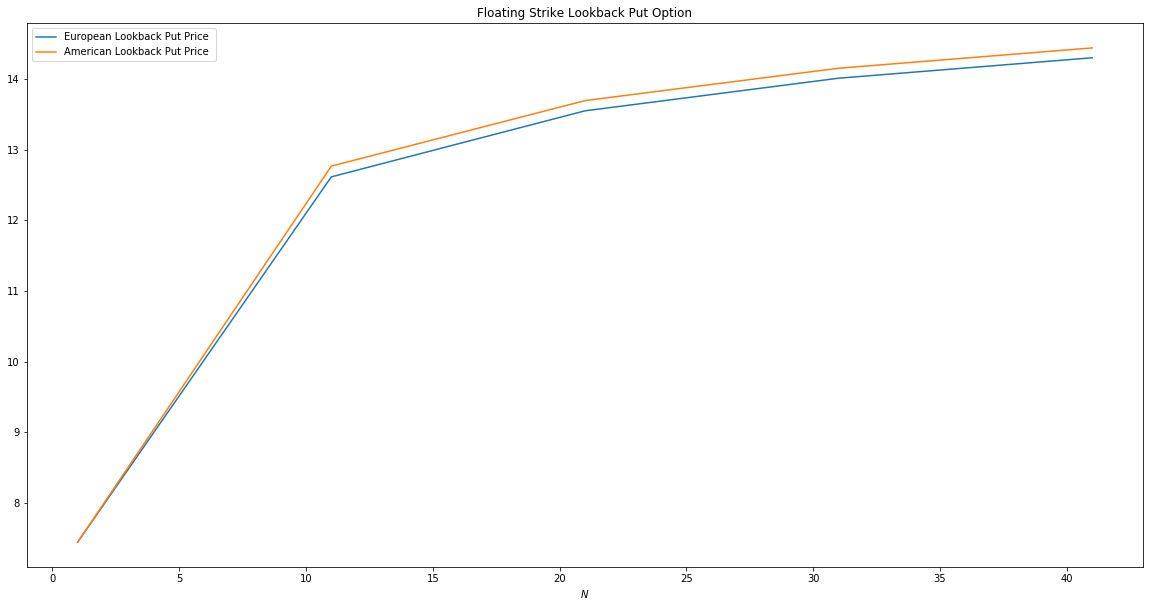

51
14.502303318366147
14.640577648906374
0.2894591080000737
0.38948986299988064


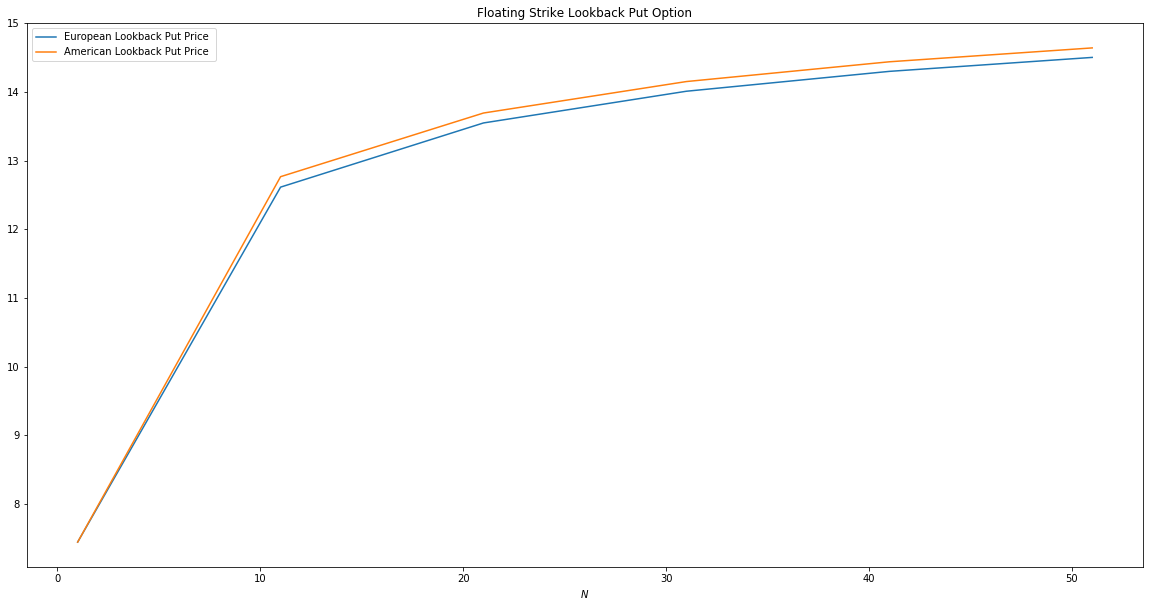

61
14.655483915513317
14.793017498729512
0.5025842100001228
0.6635477489999175


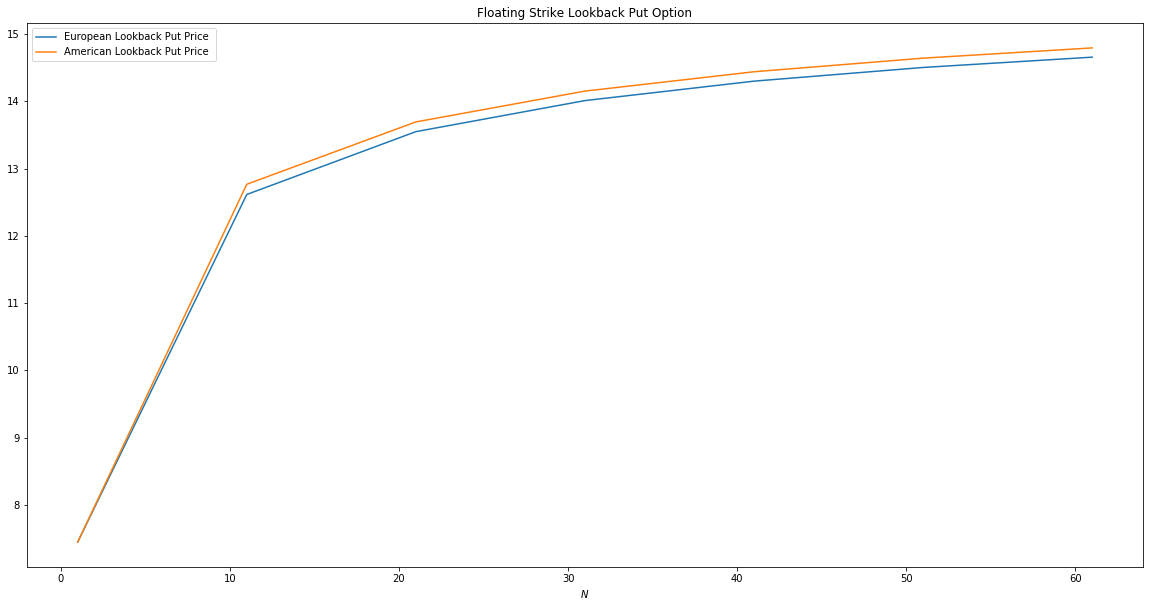

71
14.77632401069943
14.913360631729581
0.8075470339999811
1.0220341169999756


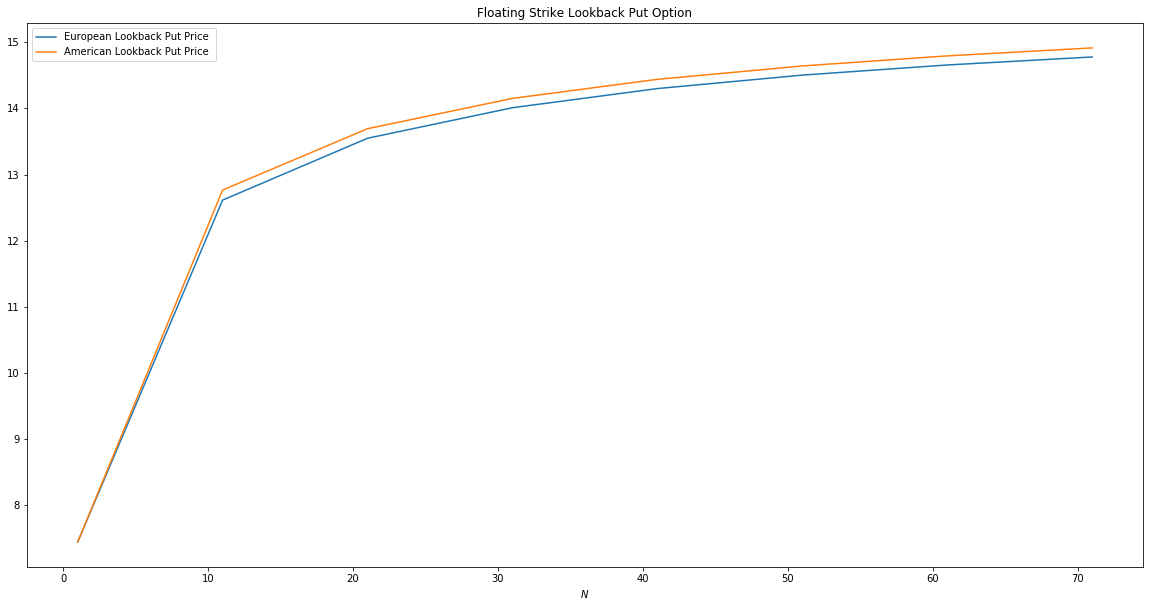

81
14.874859315774378
15.011462309397553
1.1265125159998206
1.5305140489999758


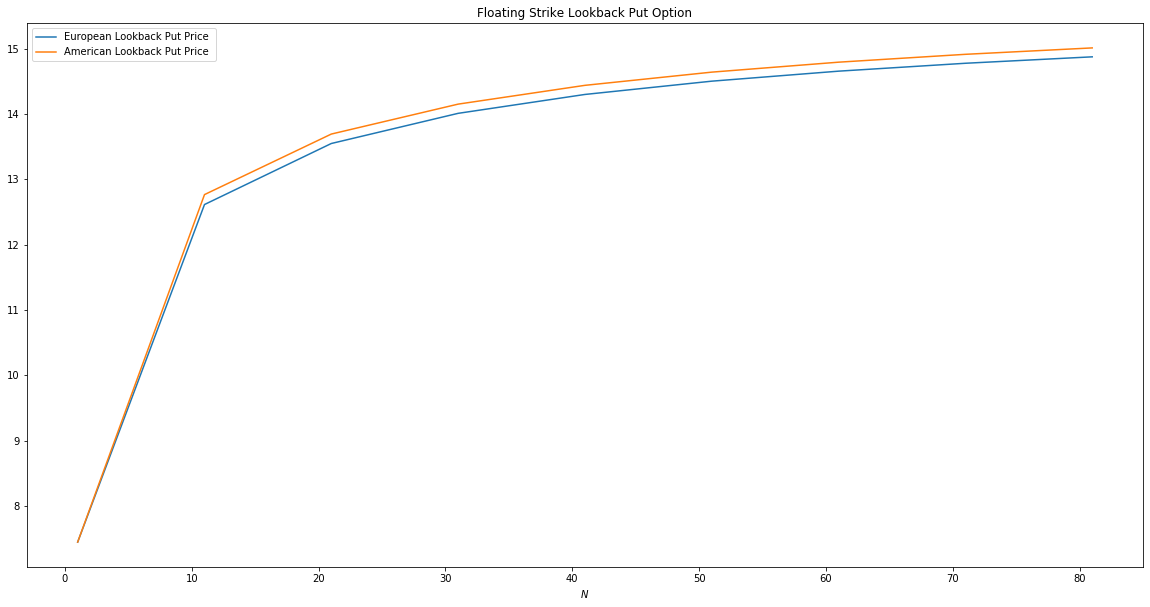

91
14.957234785653746
15.093492048582677
1.5897644439999112
2.2084654200000386


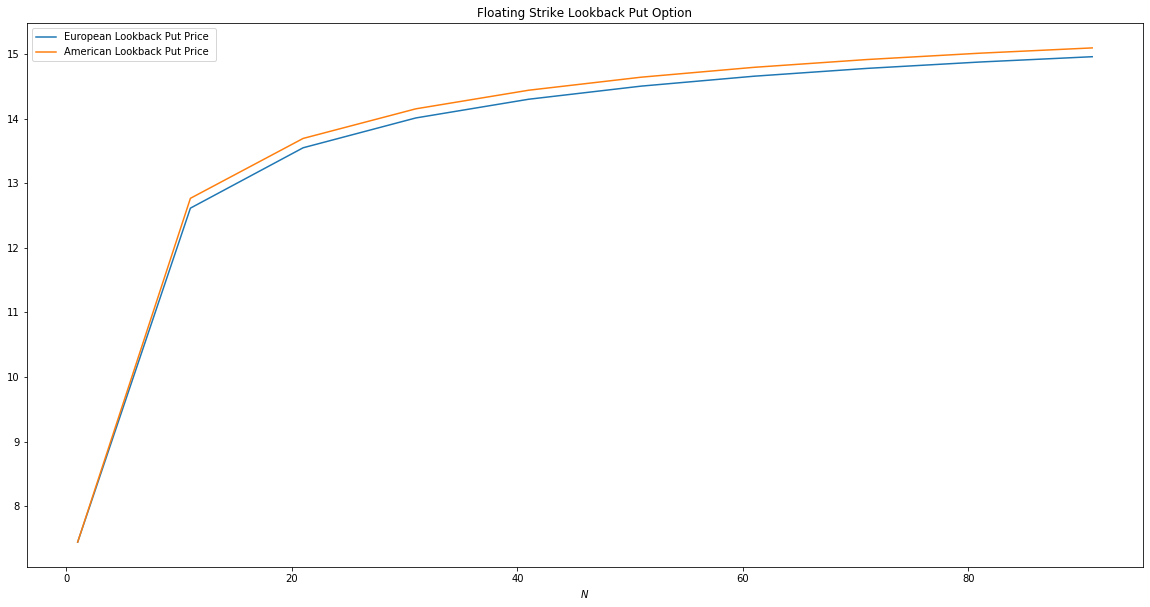

101
15.027454041416187
15.16341483719869
2.1965455130000464
2.9005580880000252


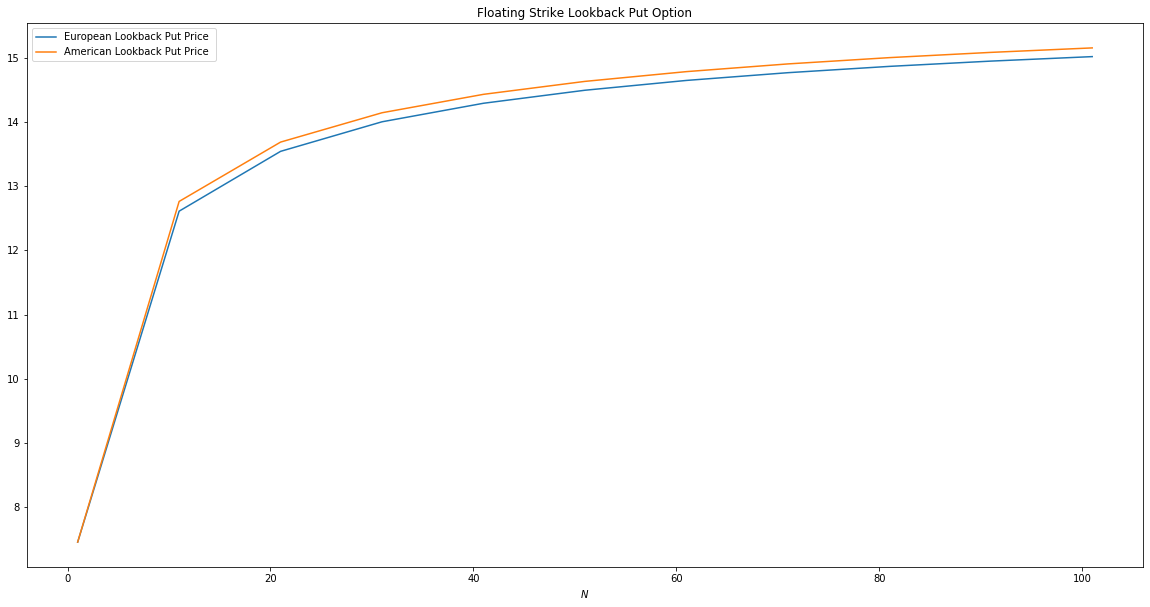

111
15.08825354682849
15.223981024667468
2.901712091999798
4.005908315999932


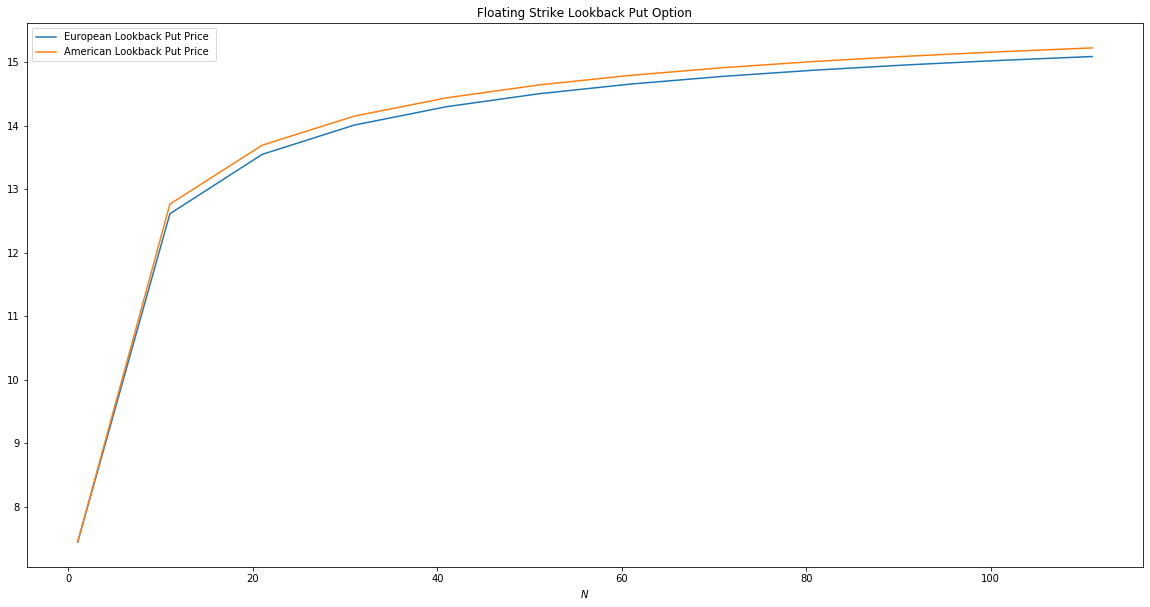

121
15.141576362625527
15.277080856547483
3.8083079840000664
5.1255601580000985


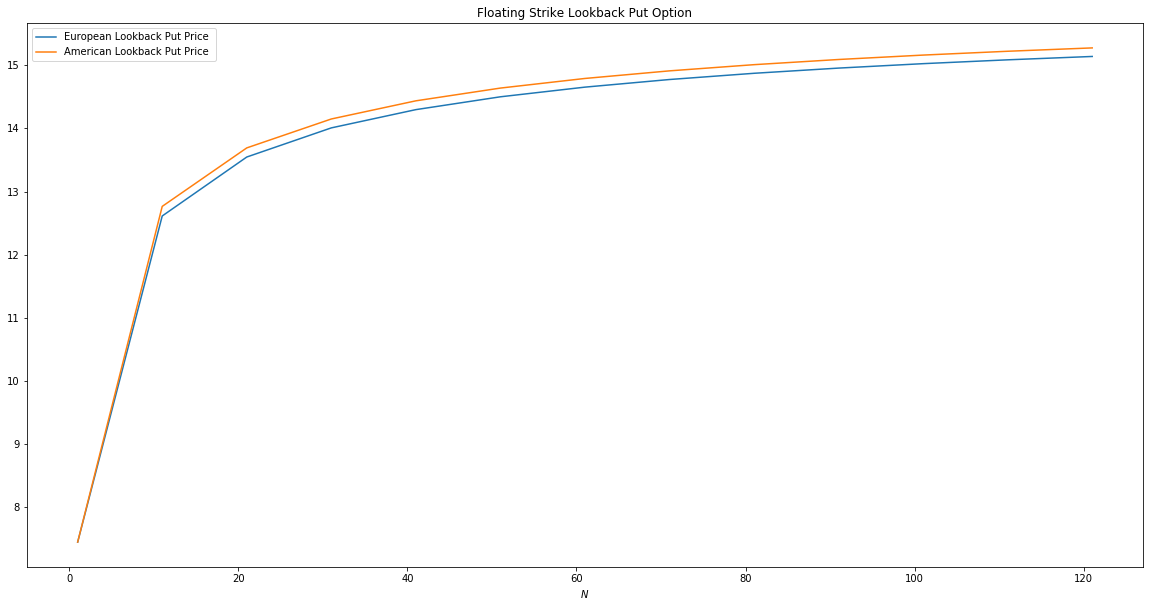

131
15.18884576944424
15.324158022457306
4.588905379999915
6.393080213000076


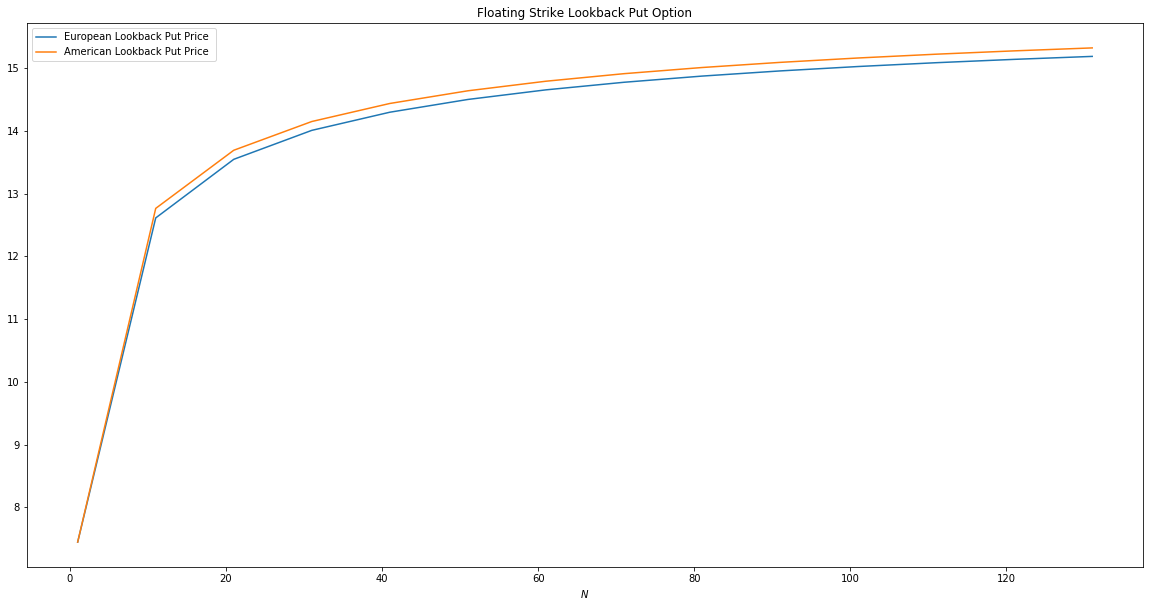

141
15.231131633424114
15.366293750751227
5.881981478000171
8.016947853999909


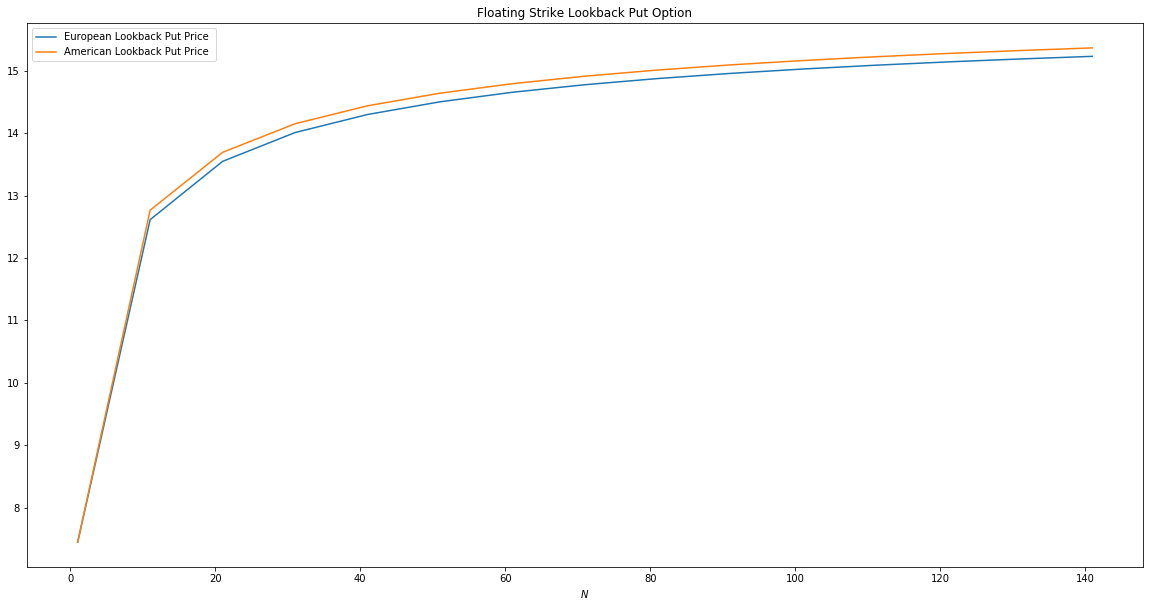

151
15.269255938923273
15.404288662500848
7.128261570999939
10.09540257499998


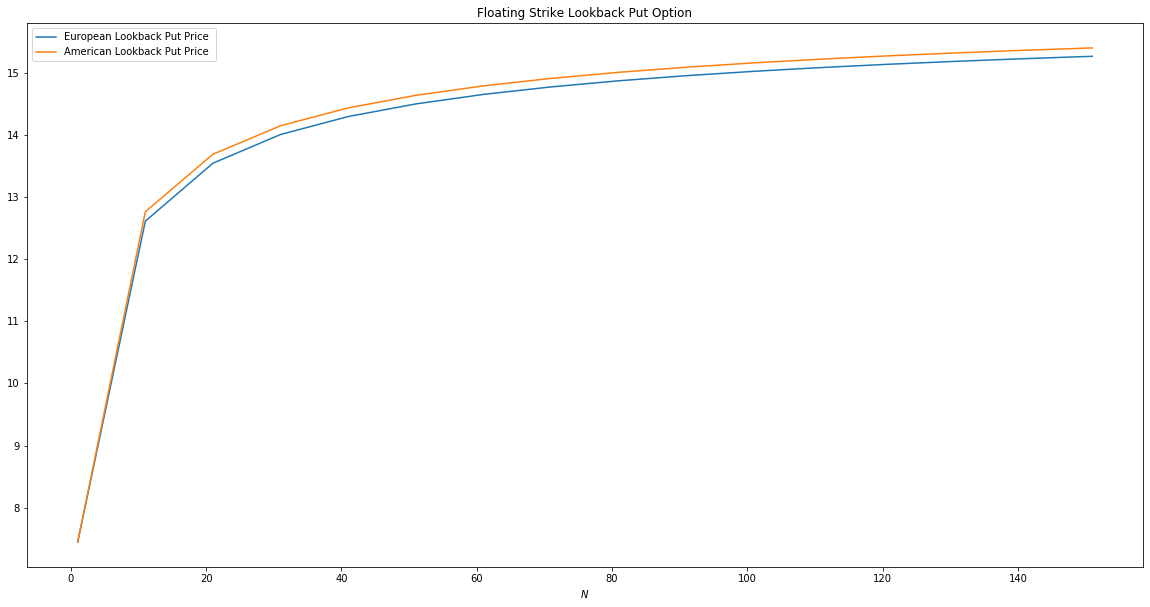

161
15.303862159785595
15.438788313538435
8.724842634999959
11.857646110999895


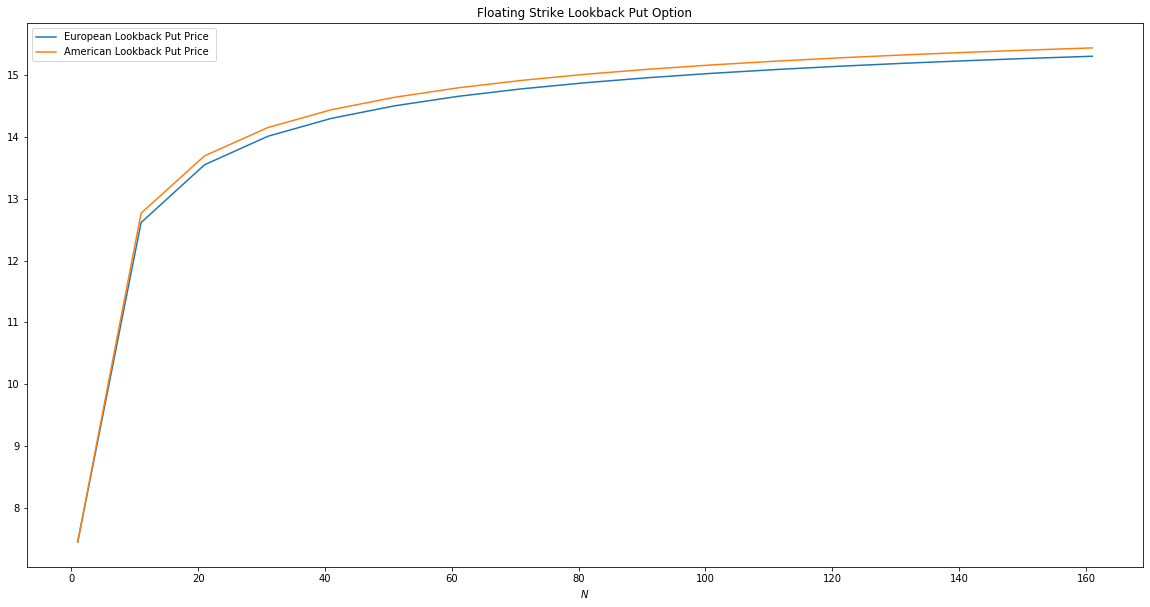

171
15.335462266104315
15.470296635430401
10.263456253000186
13.98176040500016


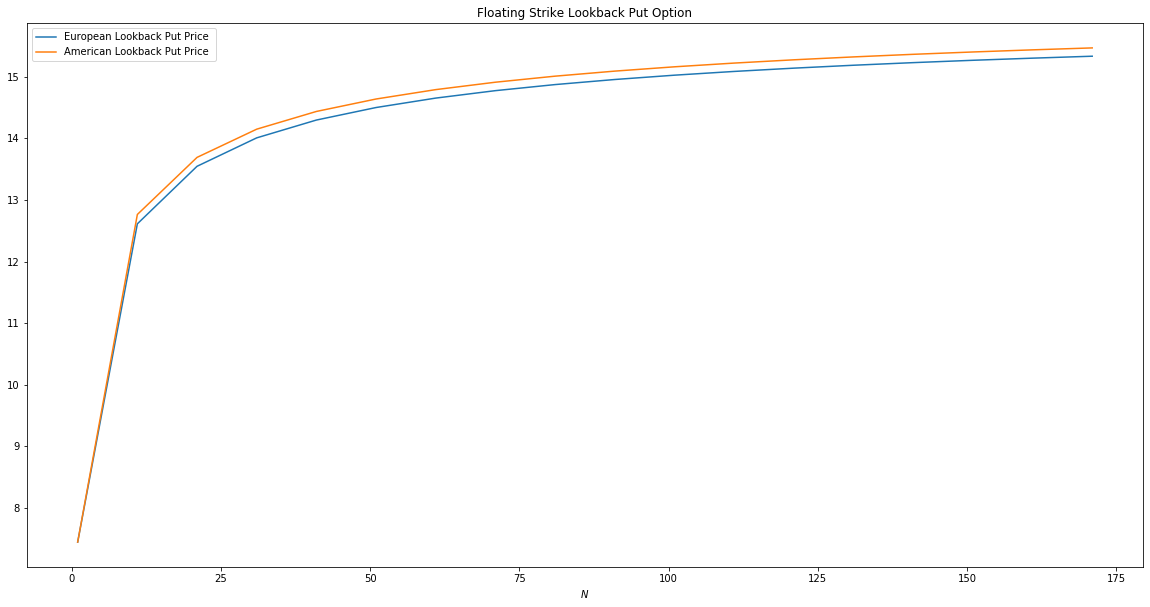

181
15.364469422467634
15.499209663065107
12.790257055999973
17.33438800099998


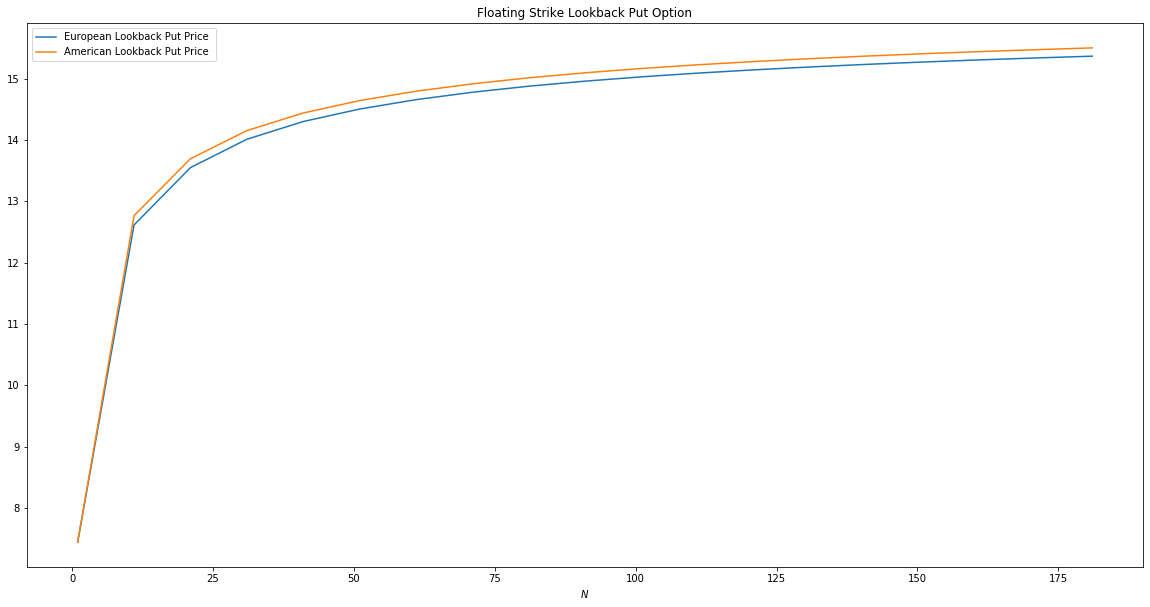

191
15.39122125908794
15.525882108909371
14.639078121000011
19.969427728000028


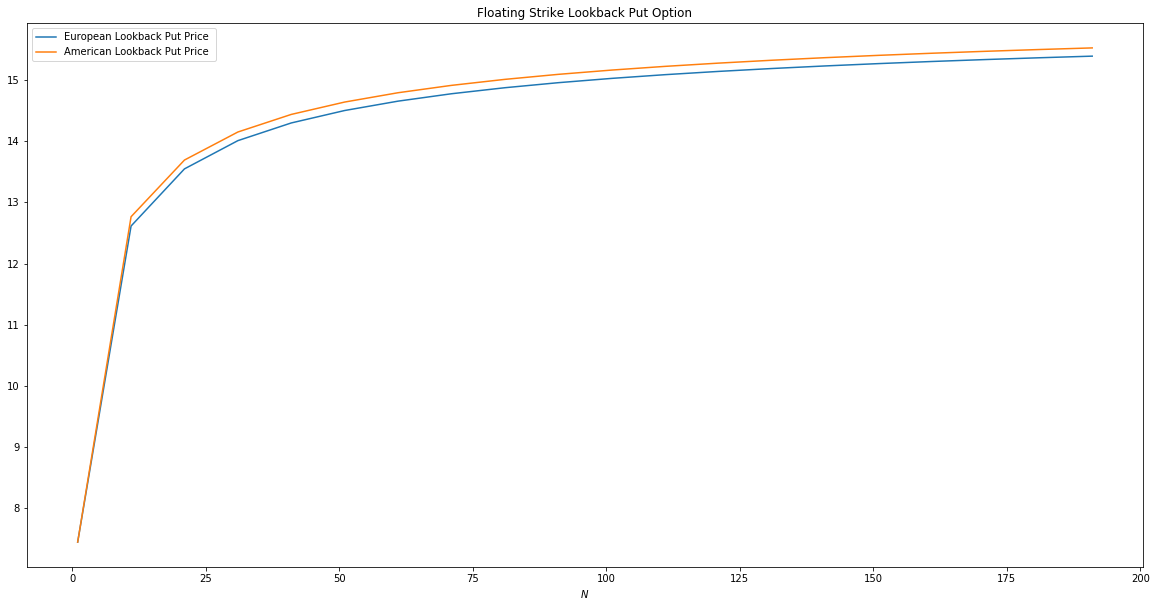

201
15.415996770375399
15.550587811046716
17.71892971500006
24.278703741000072


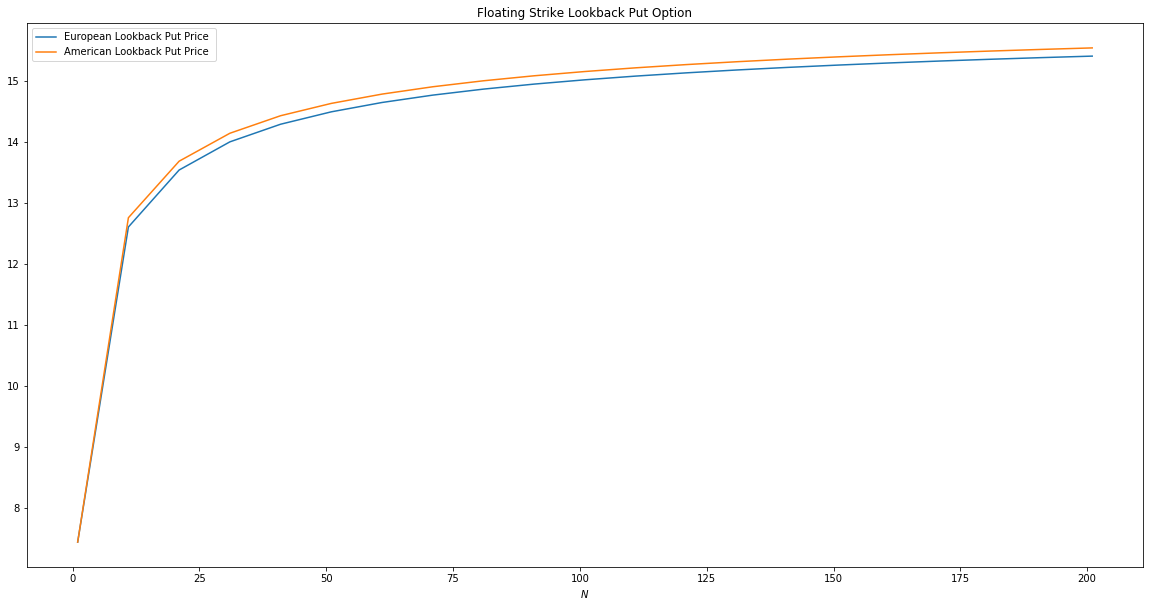

211
15.439028807042126
15.57355197036778
20.210578591000058
27.319257233000144


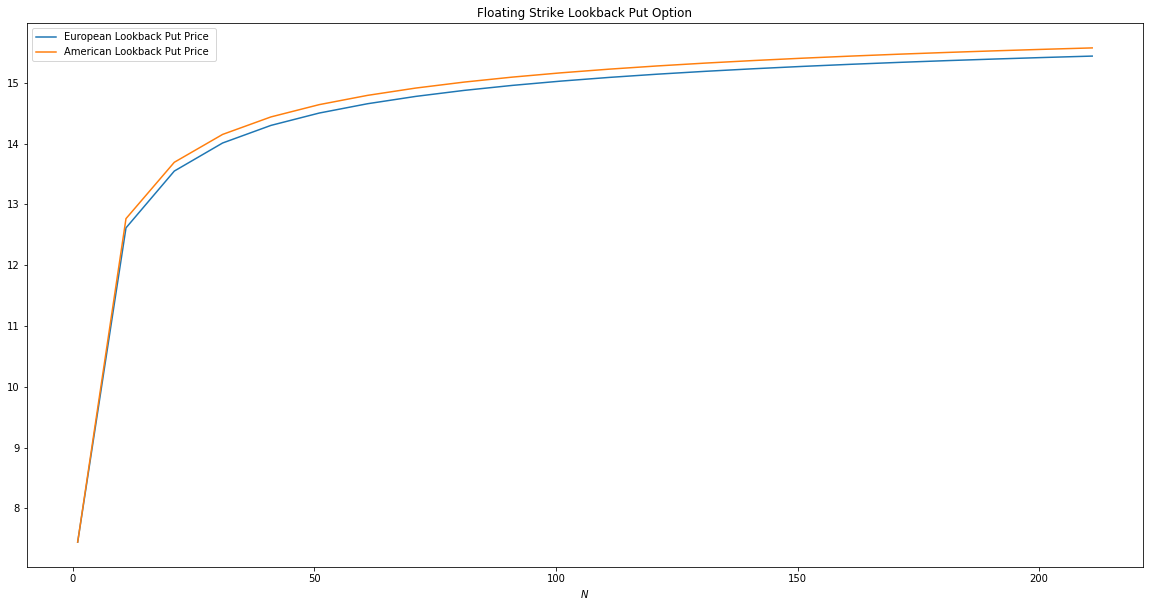

221
15.460513459232315
15.594971846904127
23.04522378200022
31.611376069000016


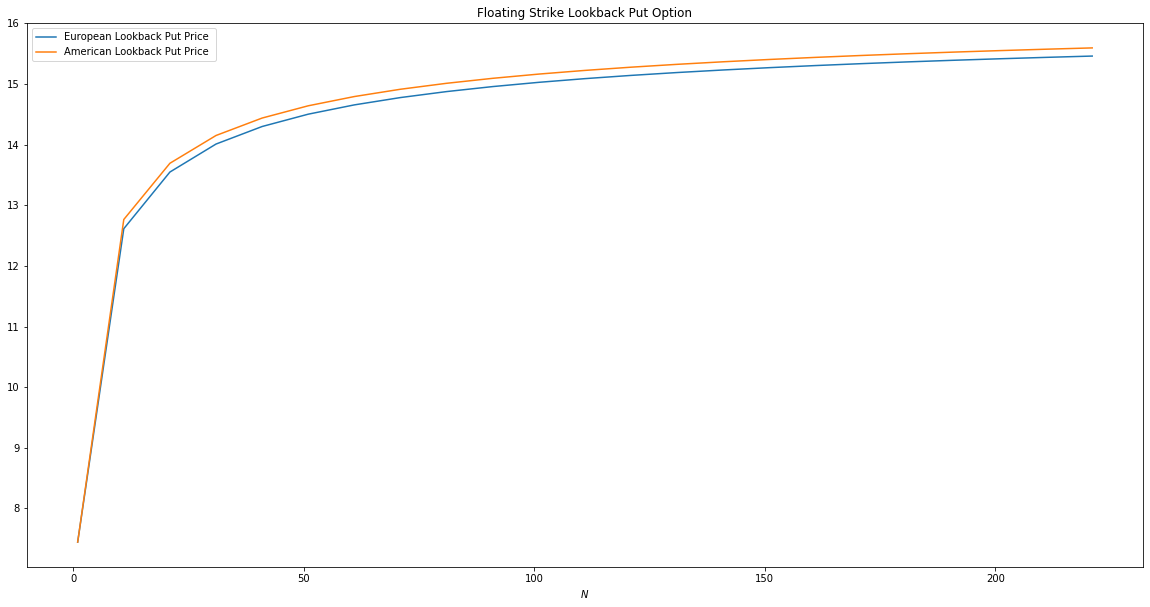

231
15.480617206188583
15.615015612130724
26.59152241700008
36.632017872999995


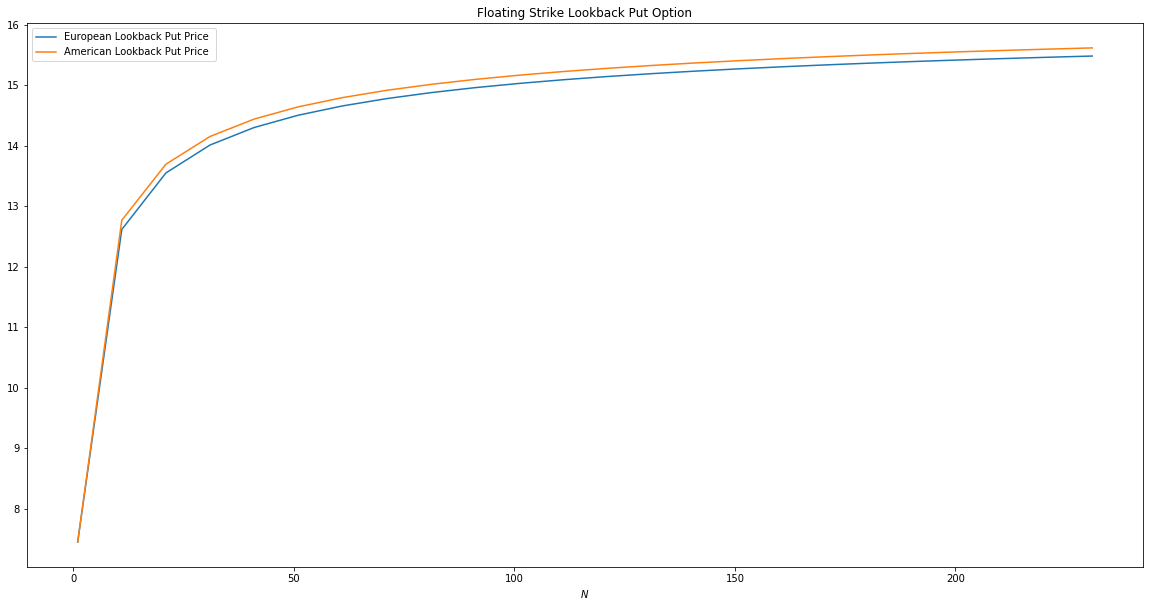

241
15.499482435135315
15.633828565264853
29.555712457000027
40.368154945000015


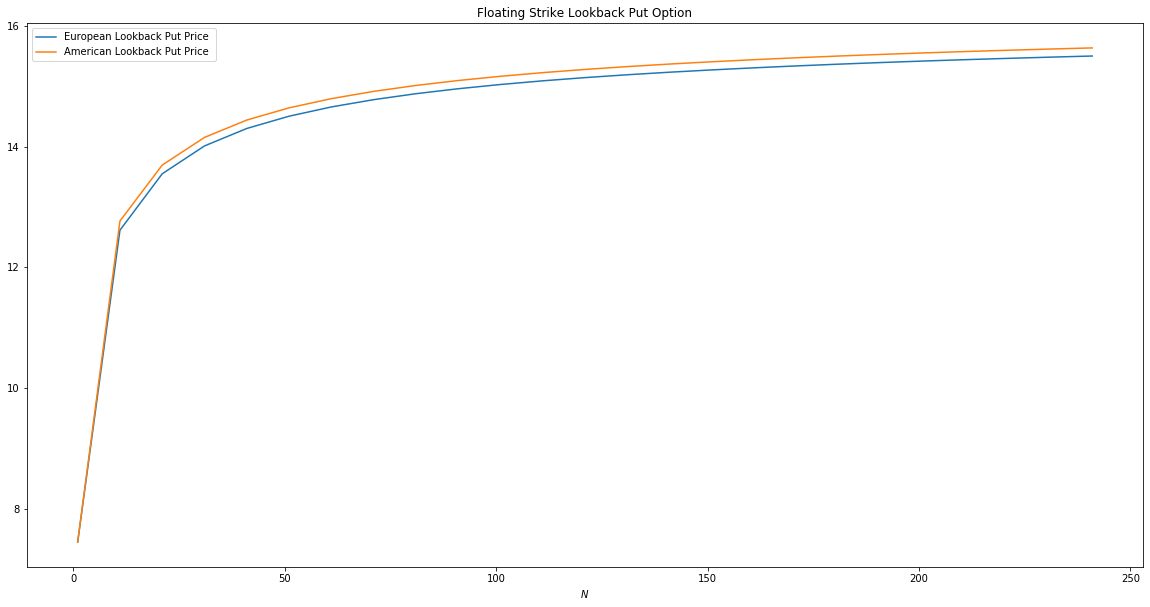

251
15.517231751794931
15.651529168355315
33.83304228099996
46.91780420700002


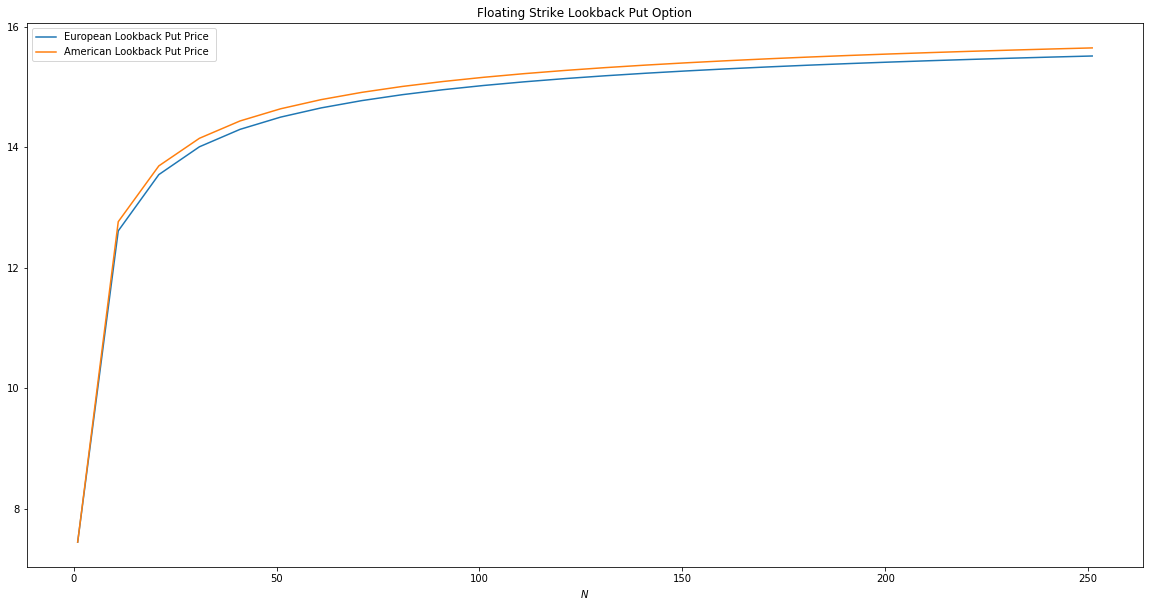

261
15.533971383452936
15.668227157588346
38.04430972200021
52.799481771000046


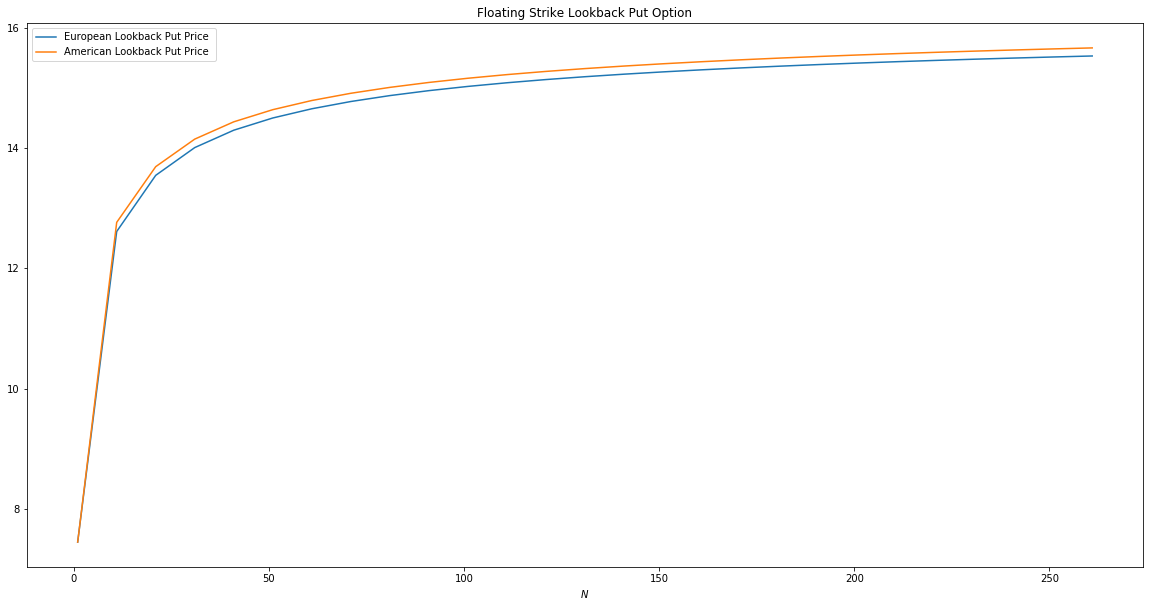

271
15.549793892181698
15.684012936741896
42.287862096000026
57.79143686799989


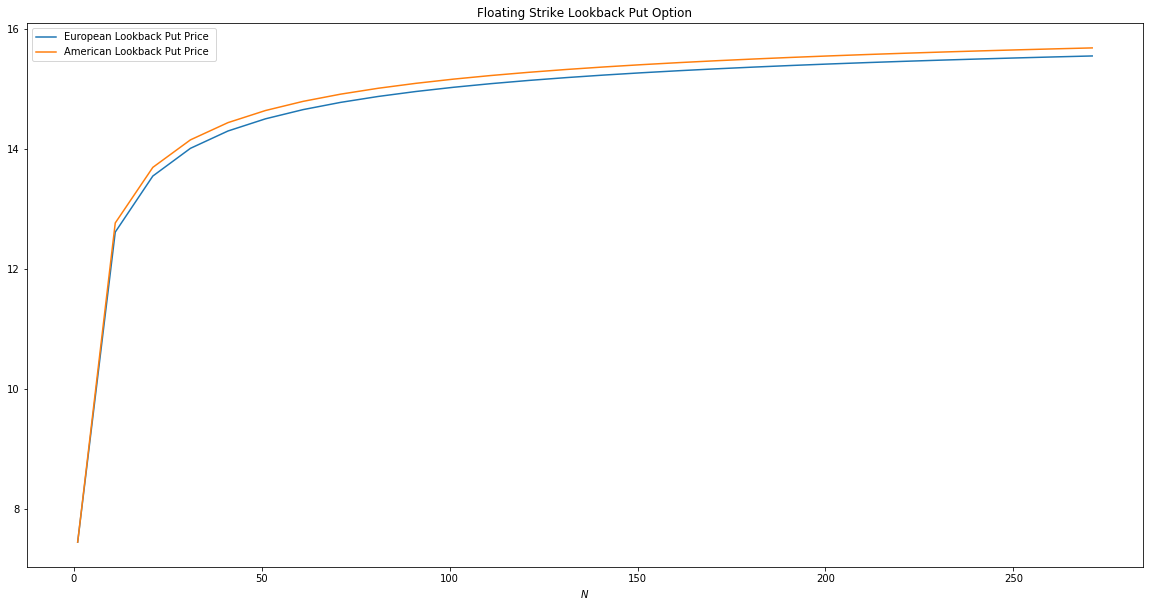

281
15.564780357727763
15.698960599969697
48.76644671000031
65.51809079999975


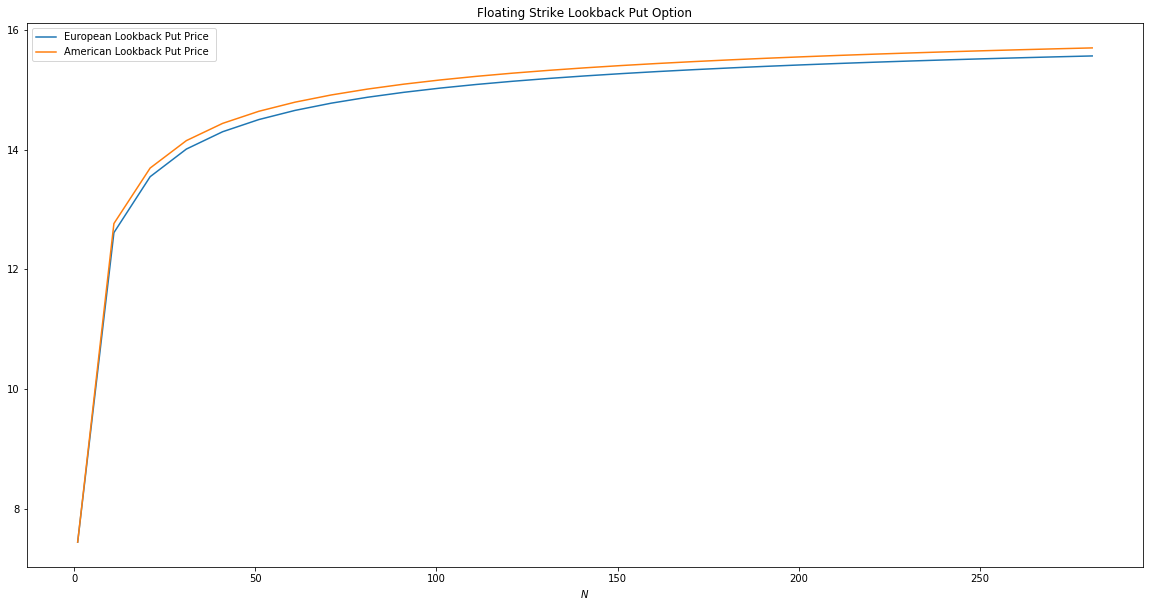

291
15.57900214844389
15.71314586526198
51.884268390000216
70.91226614299967


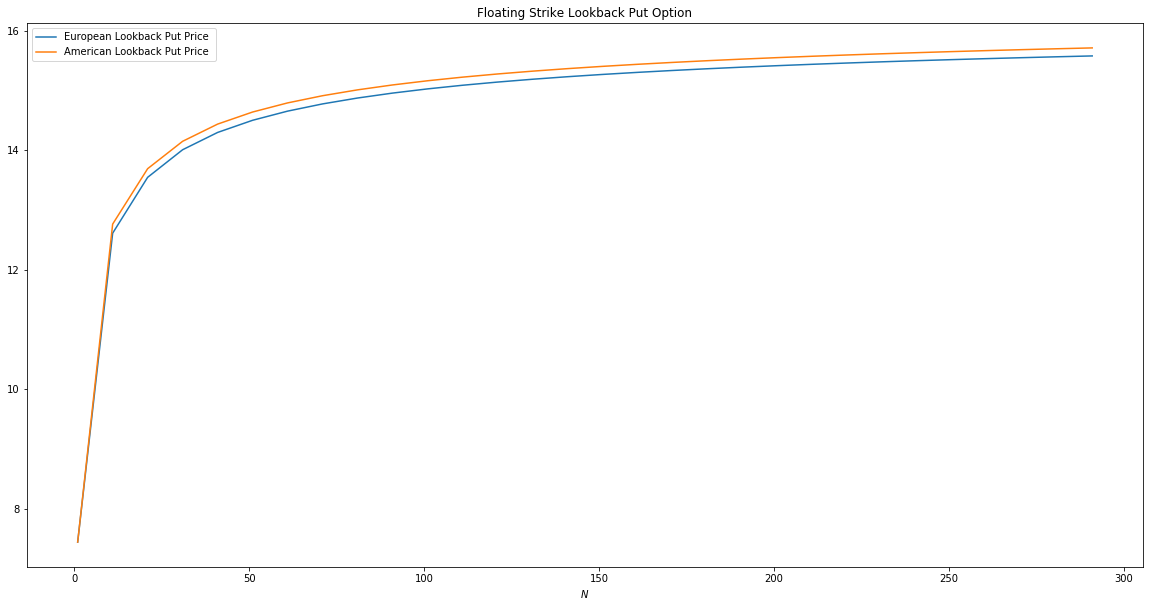

301
15.592522369162468
15.726632982541034
55.81009820400004
75.45949230699989


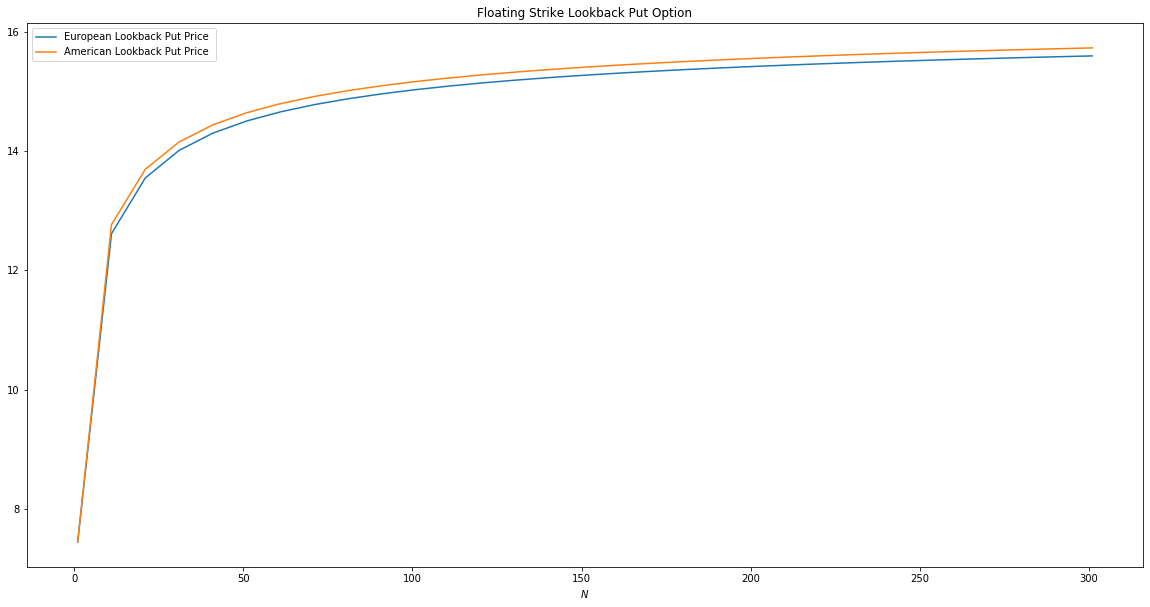

311
15.605397053467401
15.739477139815653
63.67869147200008
86.02406789600036


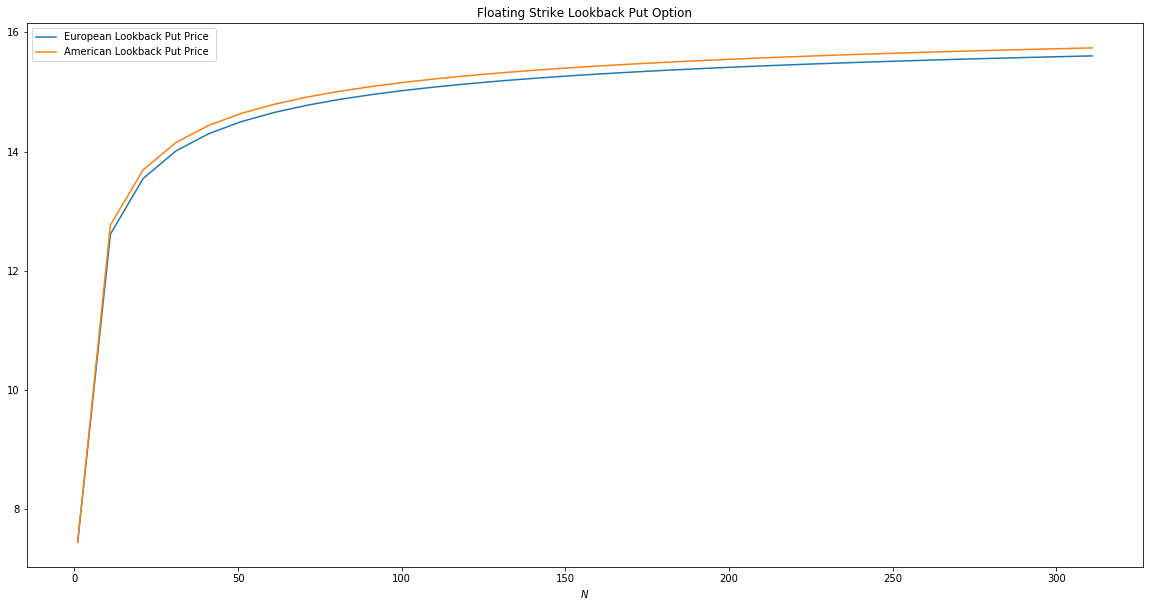

321
15.617676152073296
15.751729498453905
70.31279552099977
94.48306625399982


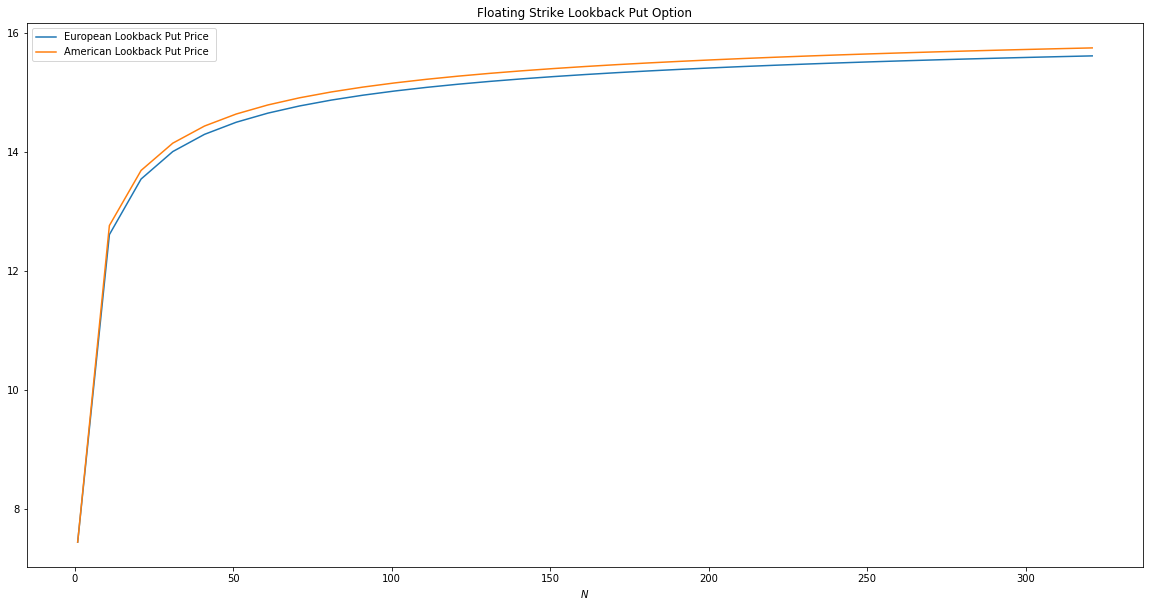

331
15.629404357286518
15.76343242998257
76.15313277400037
104.49018831800004


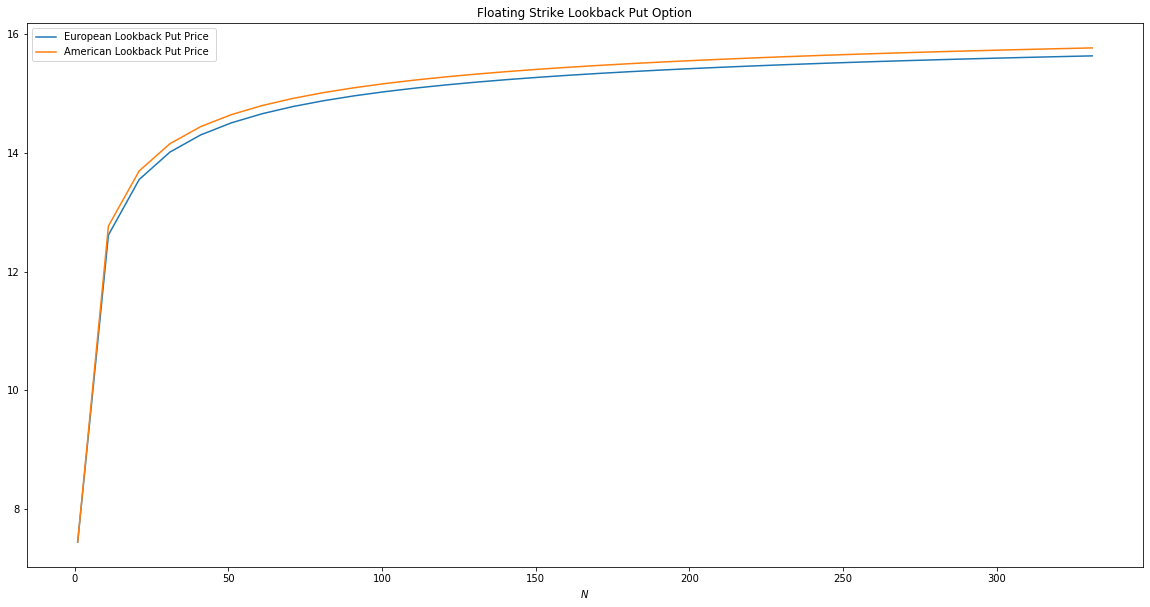

341
15.640621794783762
15.774626964097497
86.17114802100014
116.90252993399963


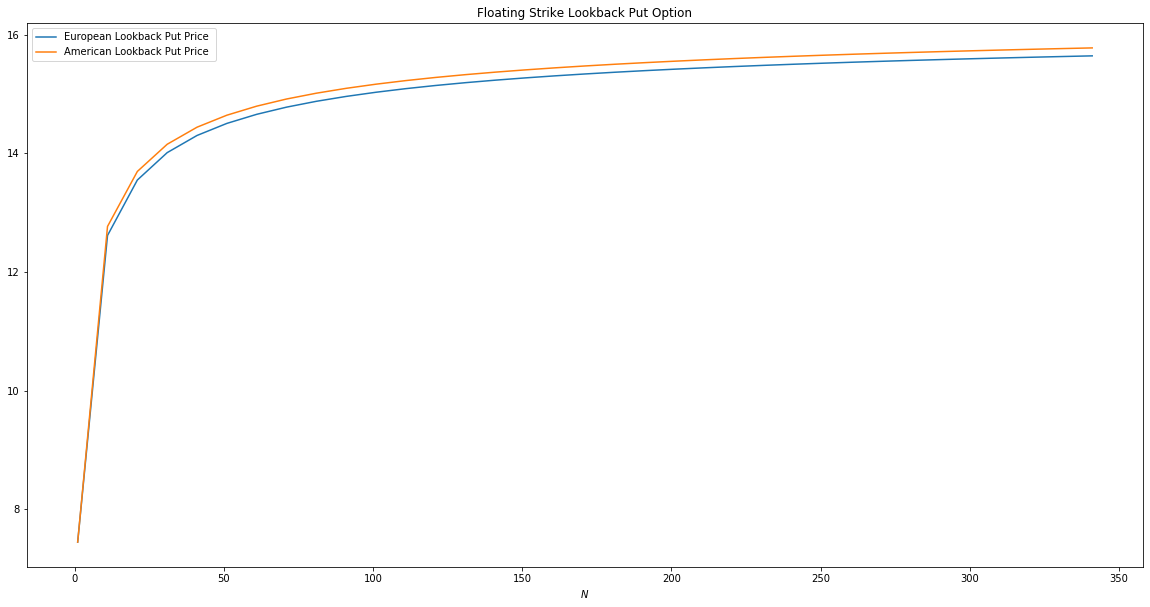

351
15.65136460720963
15.785345958186523
90.5982688920003
123.10570632200006


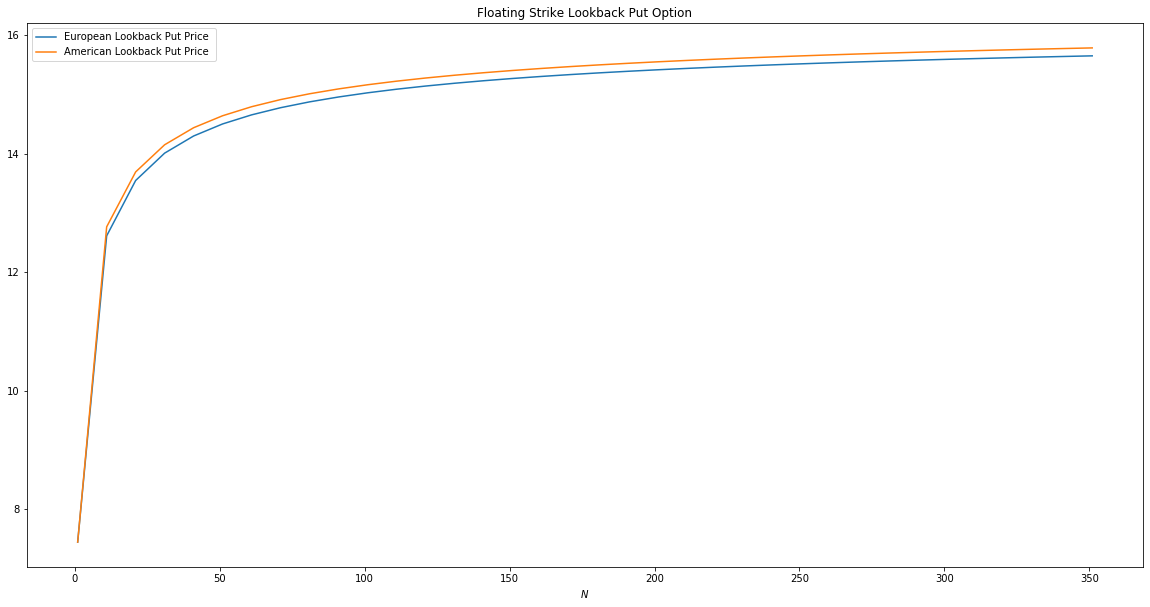

361
15.661665449075334
15.795627334673057
99.06660512000008
134.78898170799994


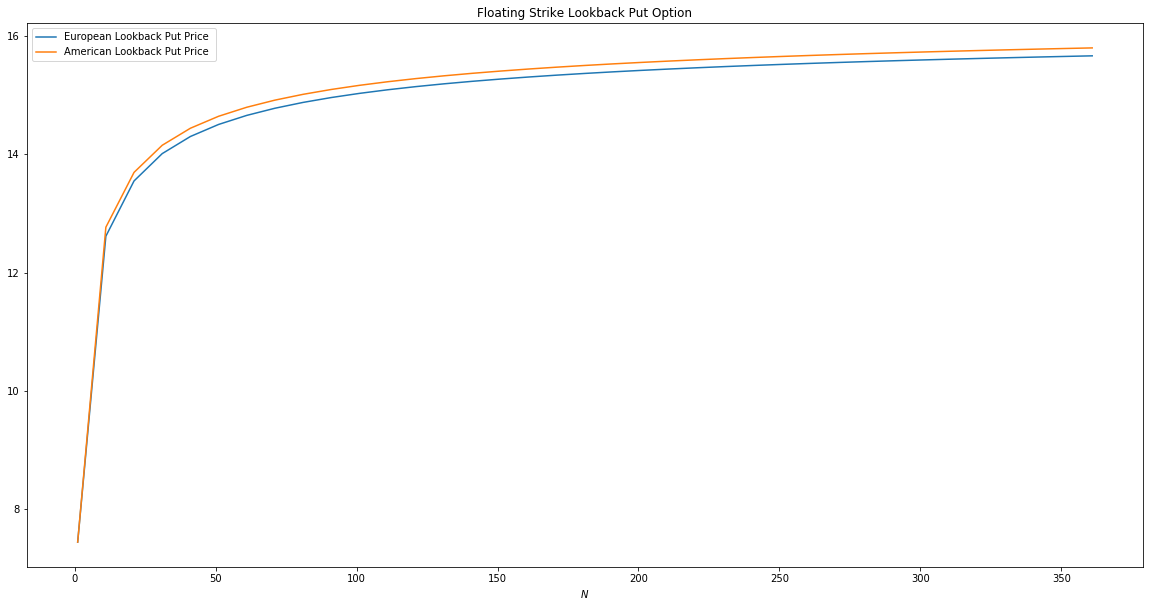

371
15.671553908449003
15.80549634481297
106.9638126750001
144.9623575139999


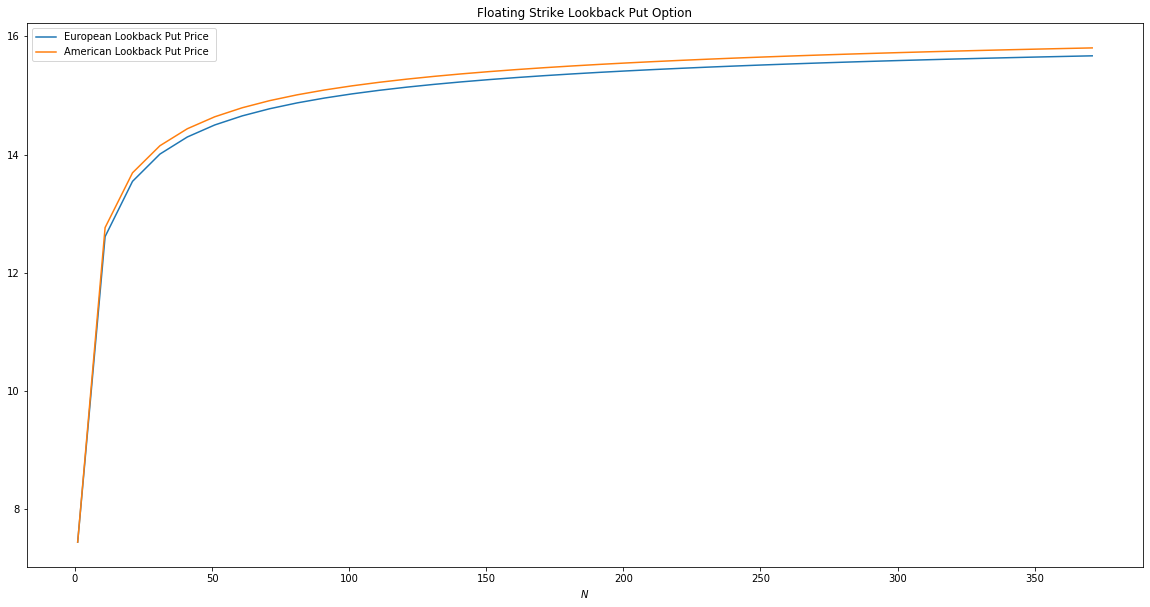

381
15.681056867924449
15.814981053928097
116.05014796999967
155.01854869700037


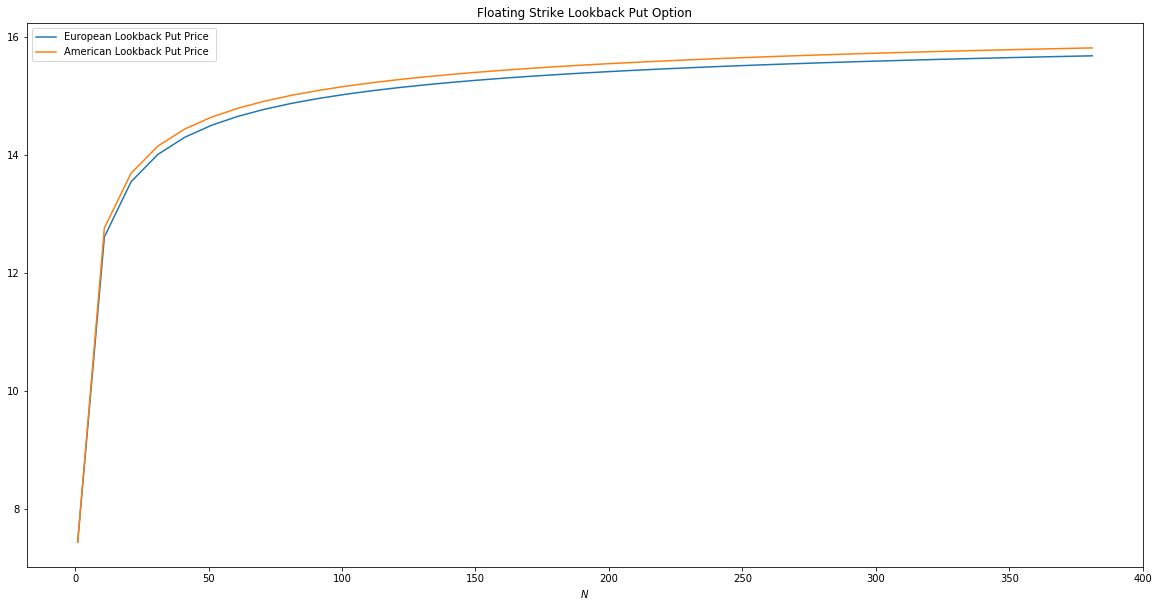

391
15.690198814941319
15.824107216753223
131.1963221119995
176.31447333100004


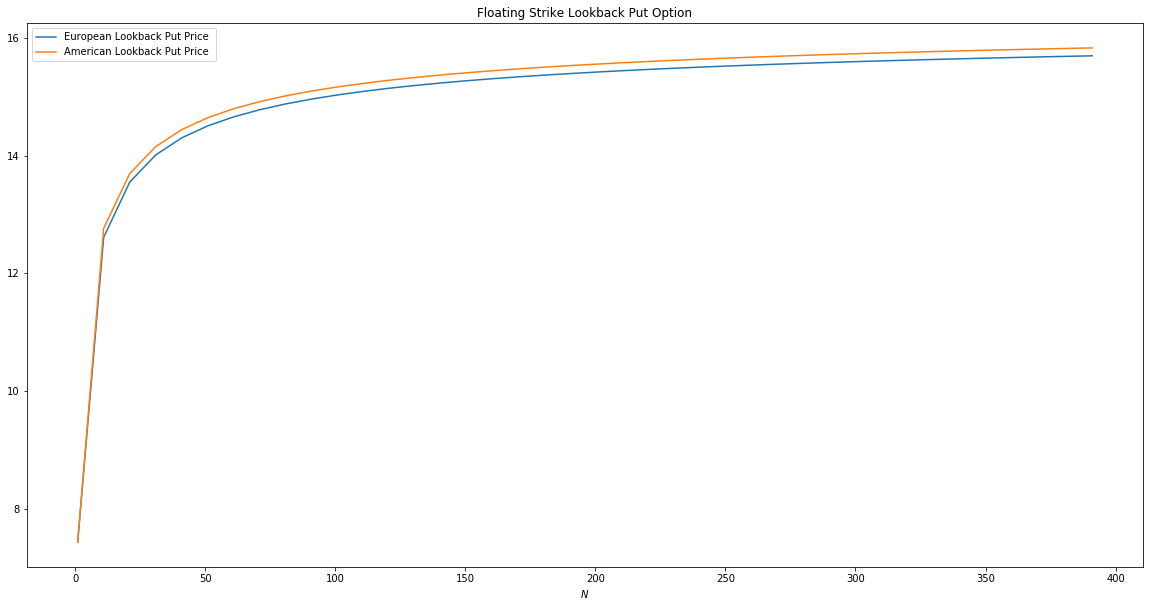

401
15.699002109635362
15.832894064640668
141.19722650200038
188.92261612699986


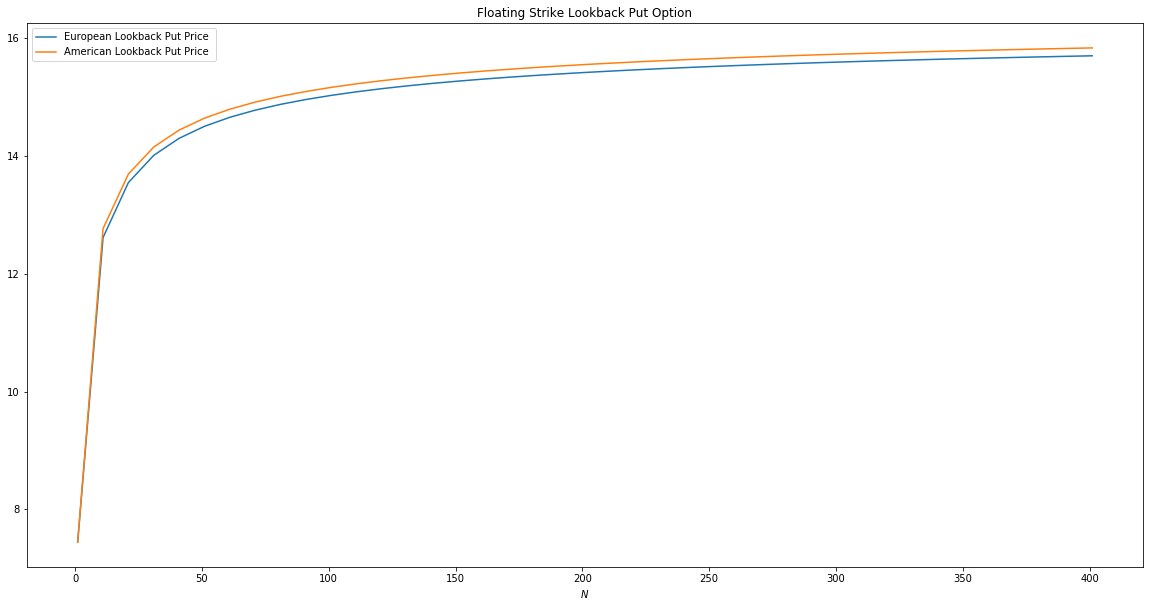

411
15.707487216956238
15.841364009411638
148.15876339999977
198.39739437200024


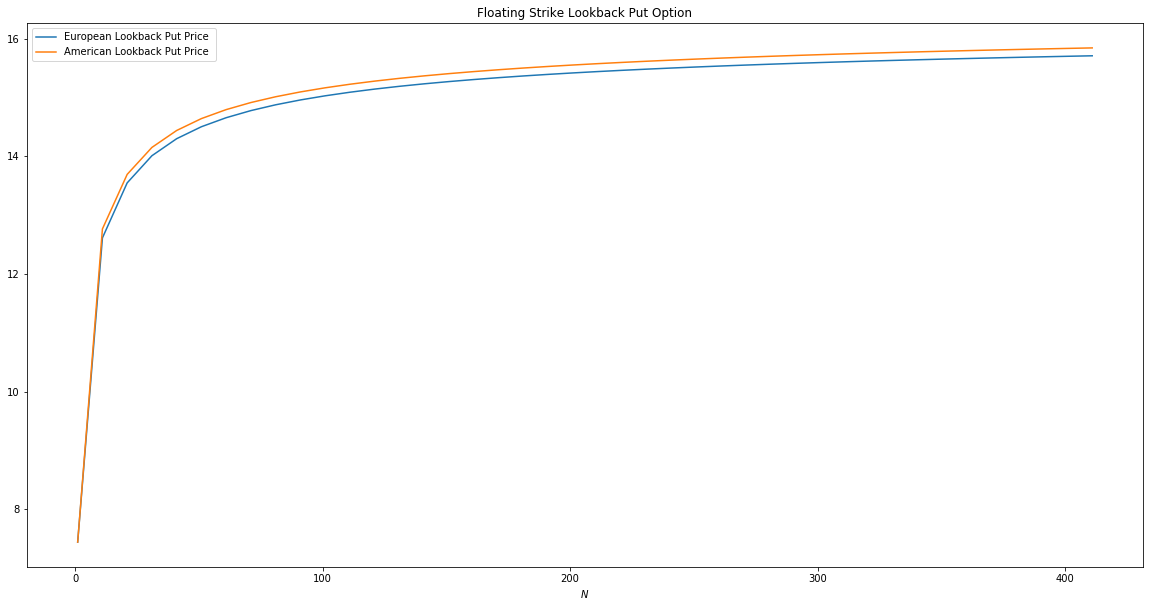

421
15.715672908523597
15.84953485998045
159.17424478199973
215.0027821929998


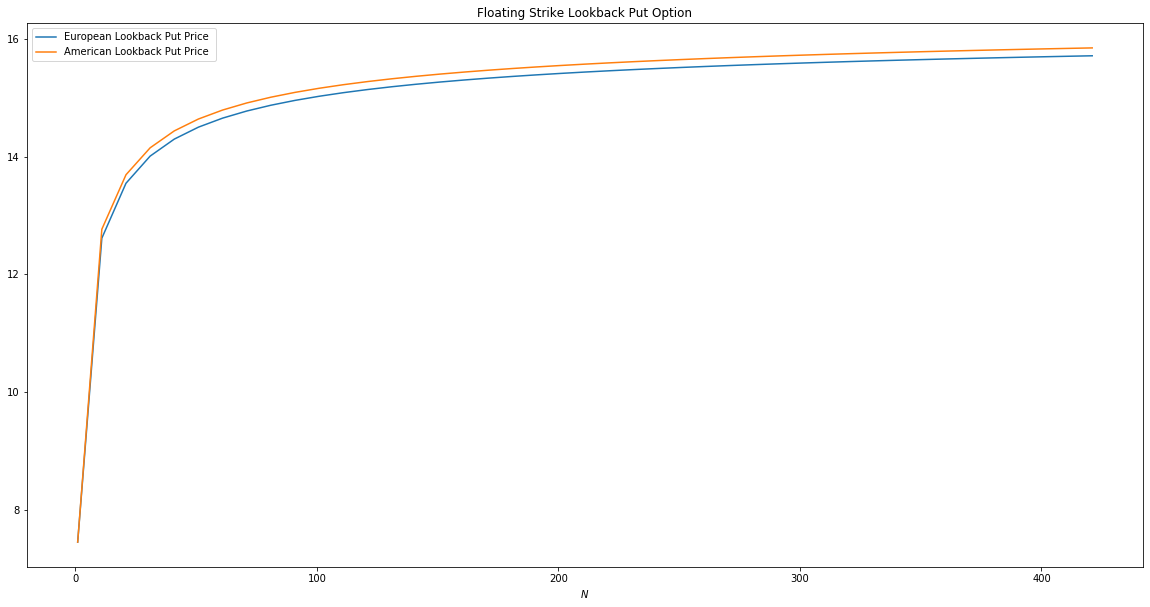

431
15.723576438801349
15.857425493111501
169.726276675
229.84095972000068


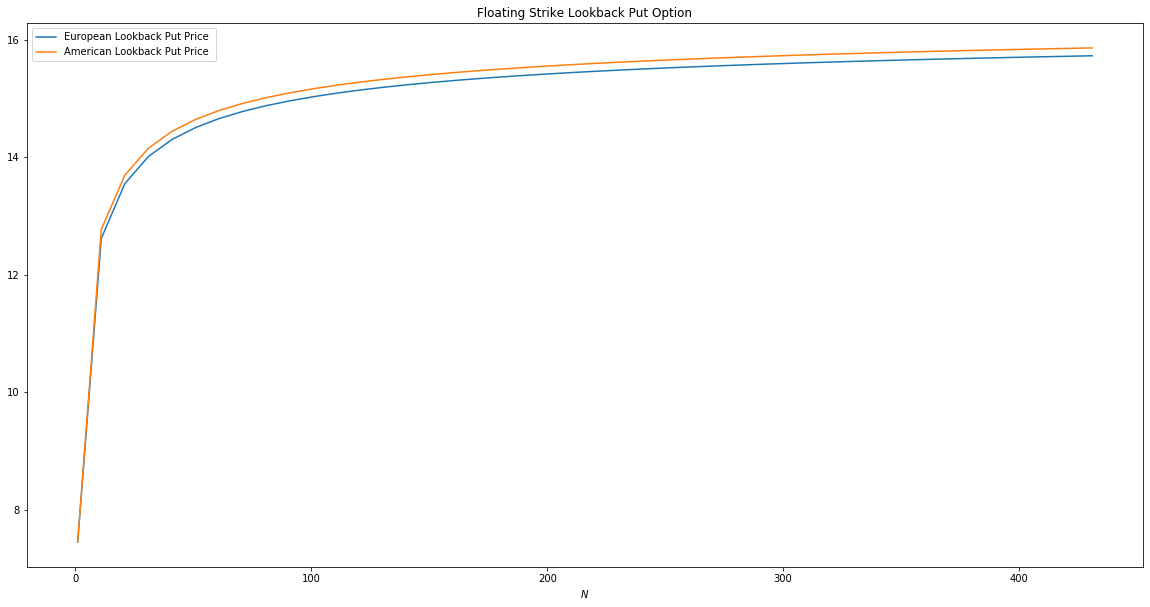

441
15.731213699362096
15.865050593674642
184.77211890999934
253.8453025379995


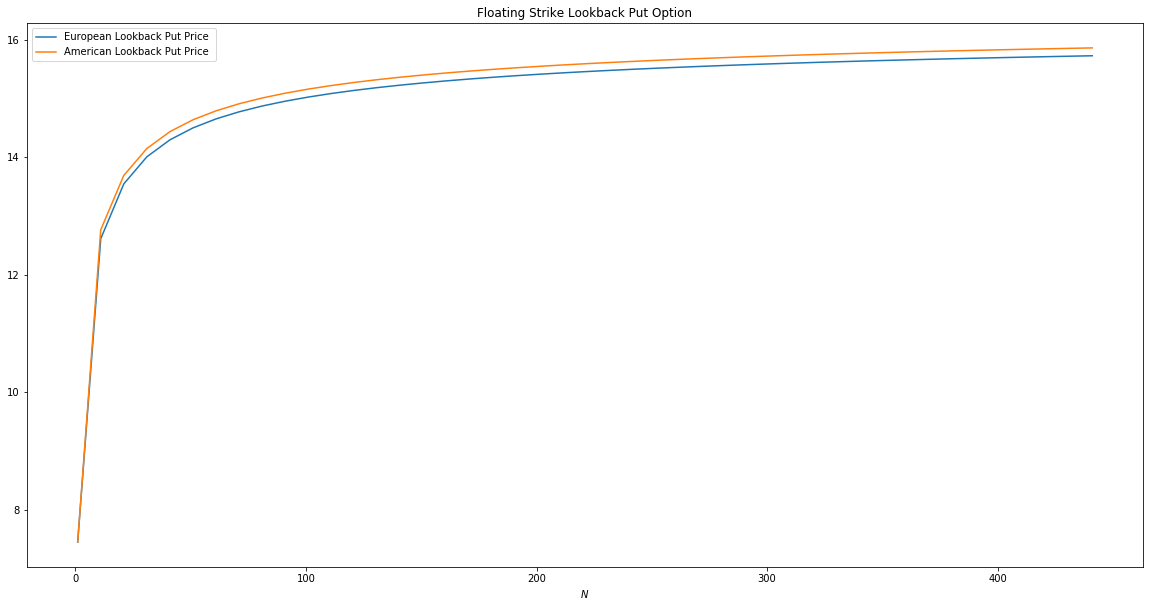

451
15.738599354372683
15.872424411895642
197.87577513999986
266.78591196899924


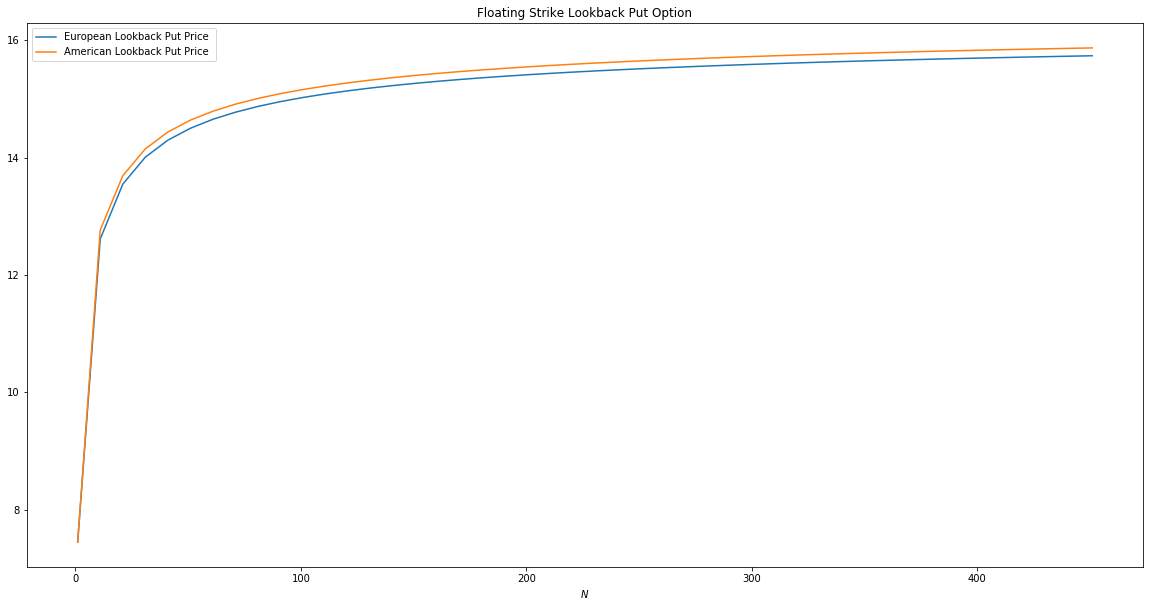

461
15.745746959987619
15.879560163520782
209.07235755200054
283.8866806019996


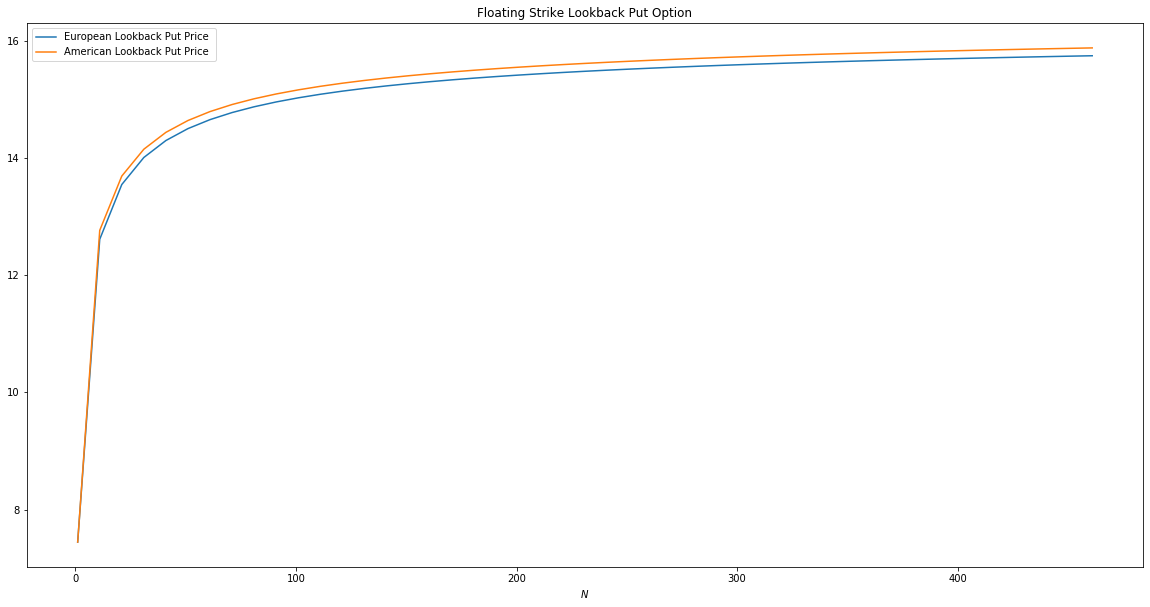

471
15.75266906981668
15.886472468877056
219.9172470630001
298.0797721130002


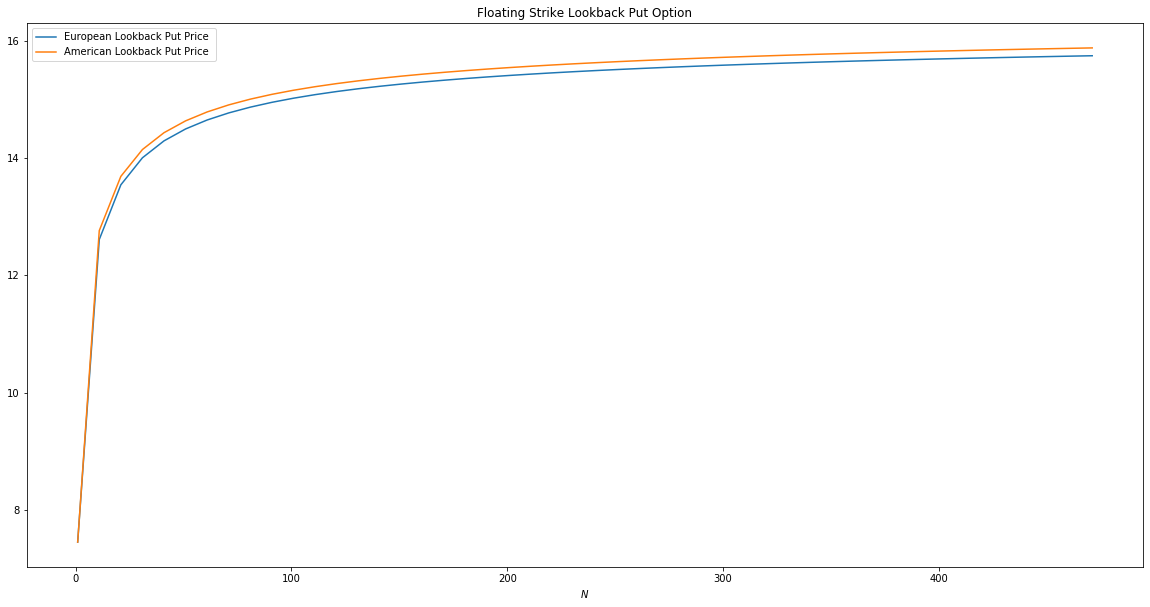

481
15.759377328375026
15.893171157670851
240.22700350600007
321.44608545899973


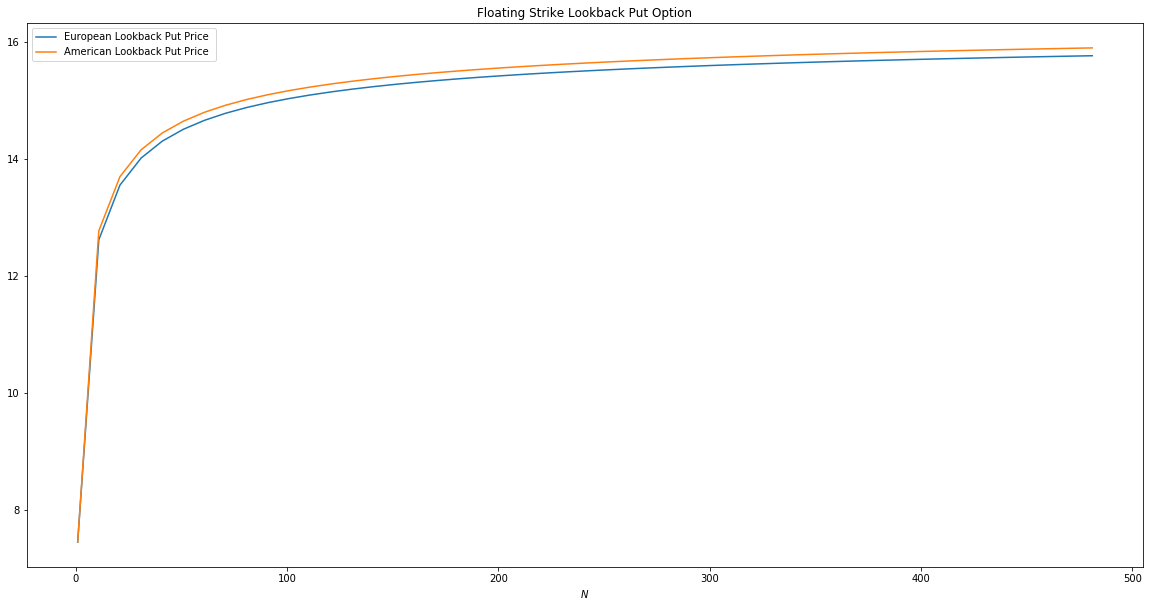

491
15.765882554097184
15.89966784151457
247.93343611899945
336.9421709899998


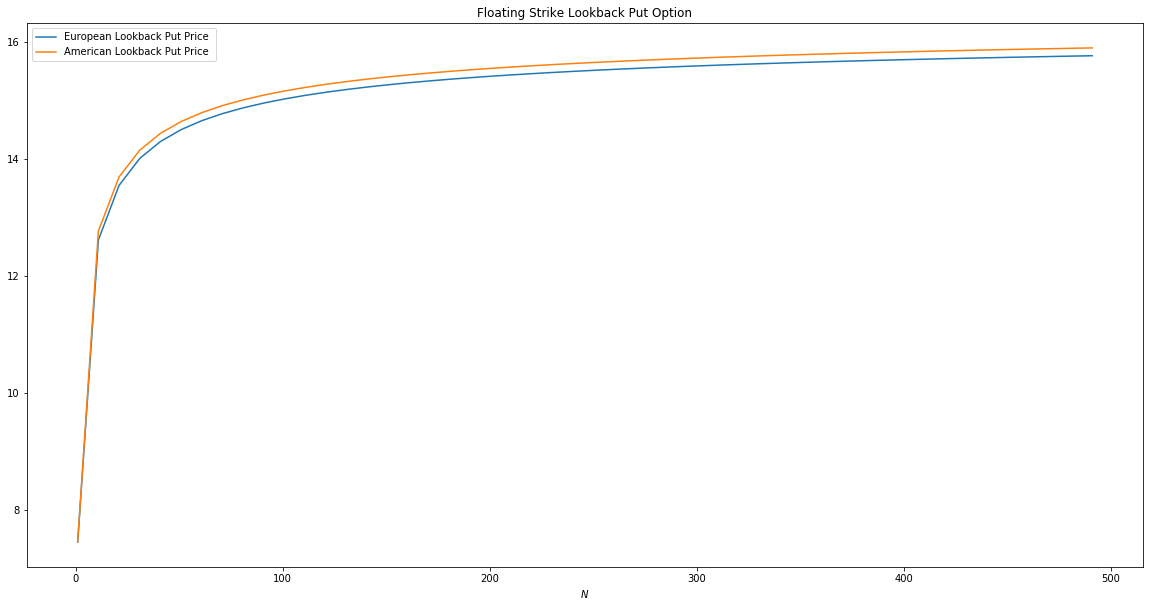

501
15.772194813263837
15.90597098823725
266.8826104079999
365.50817866299985


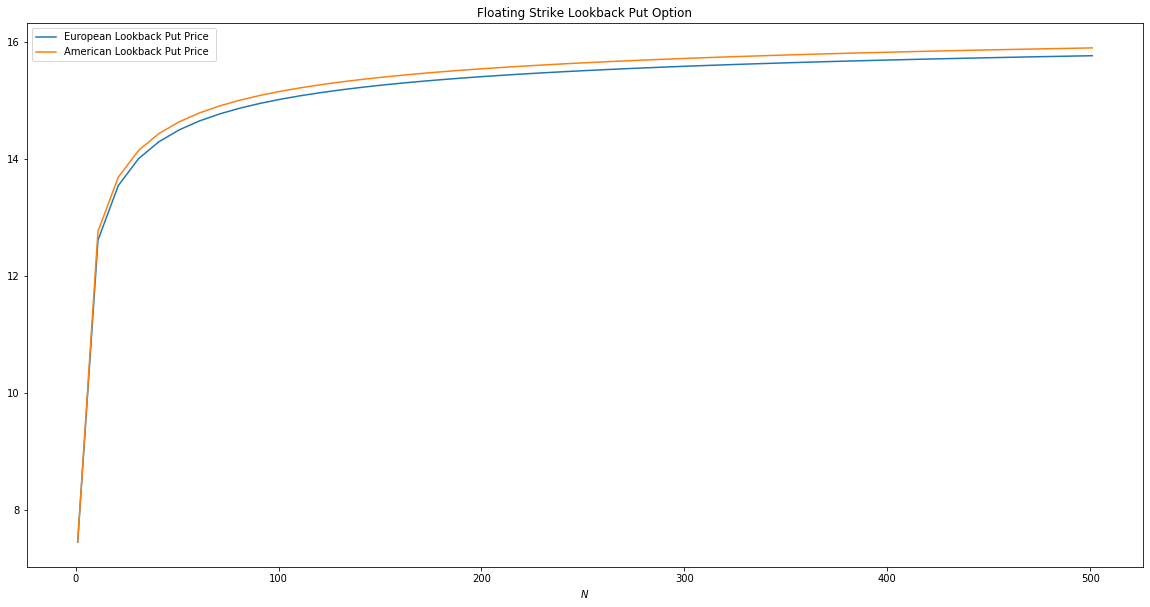

In [ ]:
PutPayoff = lambda x, y : max(x - y, 0) 

s0, r, T, sigma, lamb = 100, 0.01, 1, 0.2, 1.25
N_range = np.arange(1,502,10)
European_V_fairs = np.zeros(len(N_range))
American_V_fairs = np.zeros(len(N_range))
European_timetaken = np.zeros(len(N_range))
American_timetaken = np.zeros(len(N_range))

for i, N in enumerate(N_range):
  u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)
  start = time.process_time()     
  European_V_fairs[i] = EuroLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
  European_timetaken[i] = time.process_time() - start
  start = time.process_time()
  American_V_fairs[i] = AmerLookbackTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
  American_timetaken[i] = time.process_time() - start
  print(N)
  print(European_V_fairs[i])
  print(American_V_fairs[i])
  print(European_timetaken[i])
  print(American_timetaken[i])

  fig, ax = plt.subplots(figsize = (20, 10))
  ax.plot(N_range[:i+1], European_V_fairs[:i+1], label='European Lookback Put Price ')
  ax.plot(N_range[:i+1], American_V_fairs[:i+1], label='American Lookback Put Price ')
  ax.set_xlabel('$N$')
  ax.set_title('Floating Strike Lookback Put Option')
  ax.legend()
  plt.show()

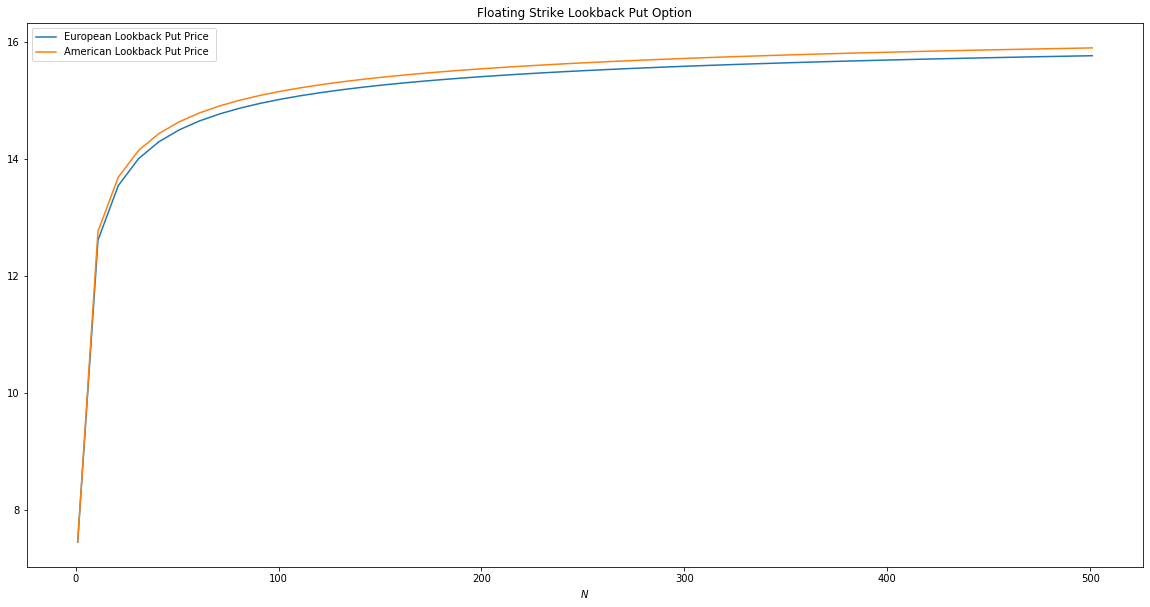

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(N_range, European_V_fairs, label='European Lookback Put Price ')
ax.plot(N_range, American_V_fairs, label='American Lookback Put Price ')
ax.set_xlabel('$N$')
ax.set_title('Floating Strike Lookback Put Option')
ax.legend()

Plot the computation time for different $N$ and find relationship.

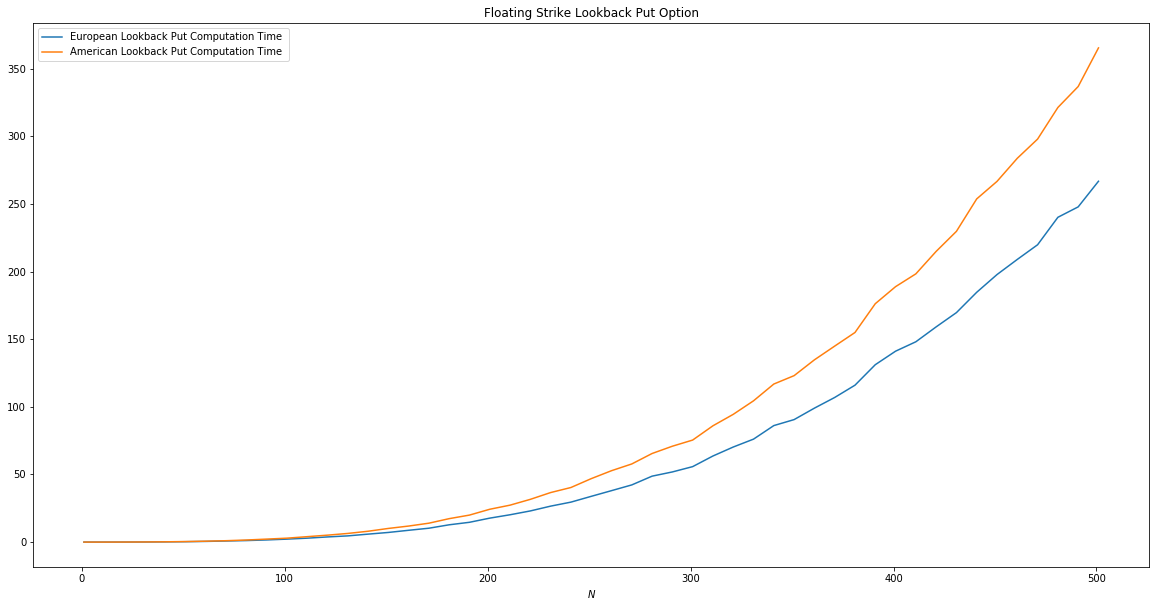

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(N_range, European_timetaken, label='European Lookback Put Computation Time ')
ax.plot(N_range, American_timetaken, label='American Lookback Put Computation Time ')
ax.set_xlabel('$N$')
ax.set_title('Floating Strike Lookback Put Option')
ax.legend()

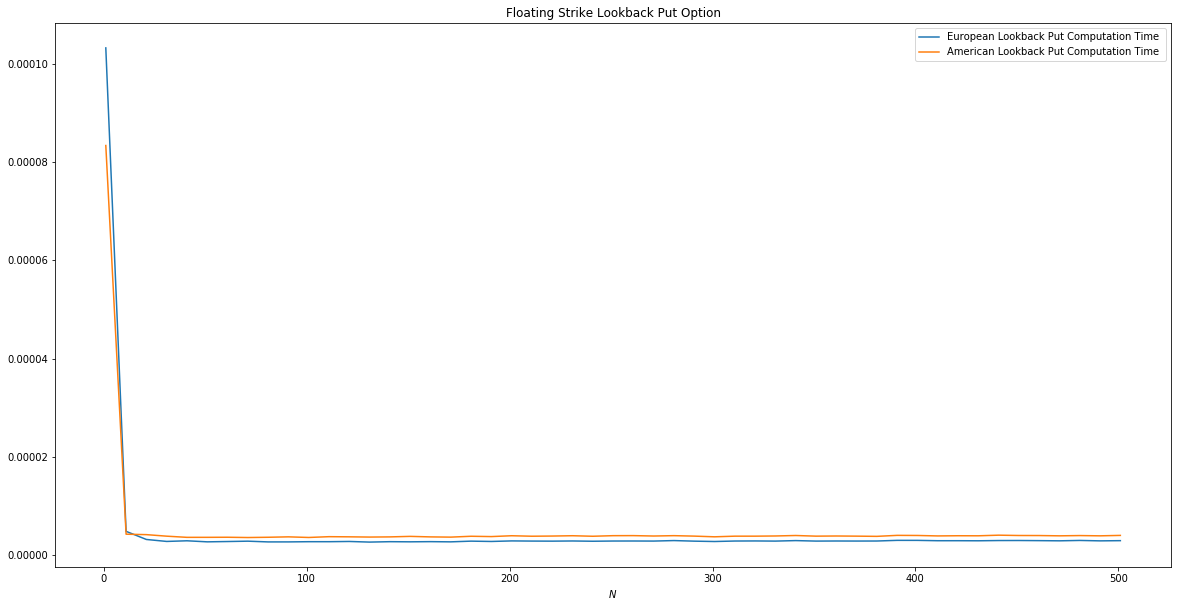

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(N_range, European_timetaken/N_range**2.95, label='European Lookback Put Computation Time ')
ax.plot(N_range, American_timetaken/N_range**2.95, label='American Lookback Put Computation Time ')
ax.set_xlabel('$N$')
ax.set_title('Floating Strike Lookback Put Option')
ax.legend()

It seems like cubic.

### Convergence Plot

In [ ]:
from google.colab import files
from google.colab import drive
import pandas as pd

In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = u"/content/drive/My Drive/Data/"
filename = u"TrinomialLookbackPutPriceConvergence.csv"

In [ ]:
convergence_df = pd.read_csv(filepath+filename)

In [ ]:
convergence_df.head()

,N,European Price,American Price,European Time,American Time
0,1,7.445940,7.445940,0.000000,0.000000
1,21,13.548086,13.692587,0.031250,0.015625
2,41,14.298957,14.438478,0.140625,0.156250
3,61,14.655484,14.793017,0.375000,0.531250
4,81,14.874859,15.011462,0.890625,1.171875


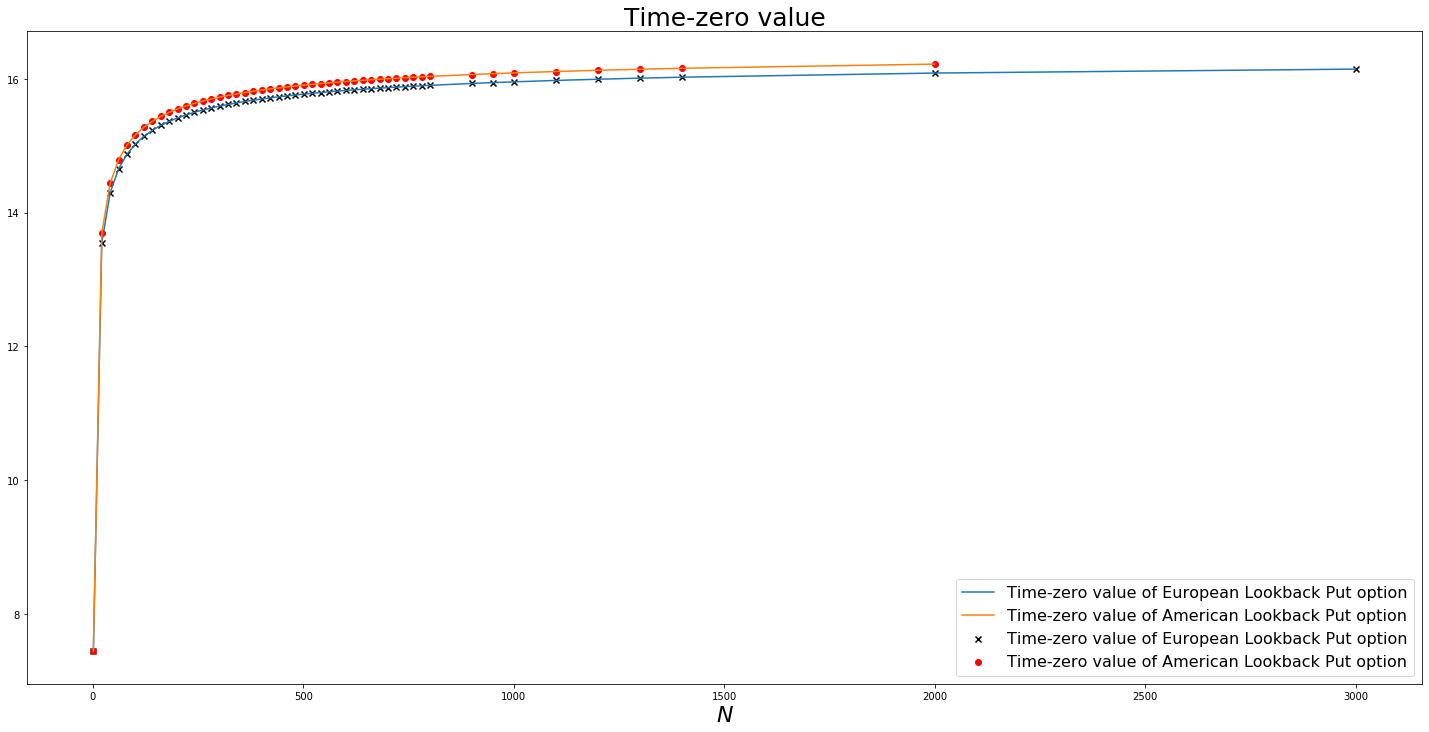

In [ ]:
fig, ax = plt.subplots(figsize=(25,12))
ax.plot(convergence_df.N, convergence_df["European Price"], label='Time-zero value of European Lookback Put option')
ax.scatter(convergence_df.N, convergence_df["European Price"], c = "black", marker = "x", label='Time-zero value of European Lookback Put option')
ax.plot(convergence_df.N[:-1], convergence_df["American Price"][:-1], label='Time-zero value of American Lookback Put option')
ax.scatter(convergence_df.N[:-1], convergence_df["American Price"][:-1], c = "red", label='Time-zero value of American Lookback Put option')
ax.set_xlabel('$N$', fontsize = 22)
ax.set_title('Time-zero value', fontsize = 25)
ax.legend(fontsize = 16)